# ロットサイズ最適化システム OptLot

>  Lotsizing Optimzation System

In [ ]:
#| default_exp lotsizing

In [ ]:
#| export
import pandas as pd
import random
import numpy as np

import sys
sys.path.append('..')

from pulp import PULP_CBC_CMD, SCIP
# Use local mypulp instead of scmopt2
from mypulp import GRB, quicksum, Model
# from scmopt2.core import *  # Comment out if not available
# from gurobipy import GRB, quicksum, Model  # Alternative import

# import scmopt2.optseq as optseq  # Comment out if not available

from sklearn.cluster import AgglomerativeClustering
import plotly.express as px
import plotly.graph_objs as go
import plotly.express as px
import plotly
from plotly.subplots import make_subplots

import pathlib
import statistics

from collections import defaultdict

from openpyxl import Workbook, load_workbook
from openpyxl.worksheet.table import Table, TableStyleInfo
from openpyxl.chart import ScatterChart, Reference, Series
from openpyxl.worksheet.datavalidation import DataValidation
from openpyxl.formatting.rule import ColorScaleRule, CellIsRule, FormulaRule
from openpyxl.styles import Color, PatternFill, Font, Border, Alignment
from openpyxl.styles.borders import Border, Side
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.comments import Comment

folder ="./data/"

## 簡易システムの紹介ビデオ

ロットサイズ最適化システム OptLot

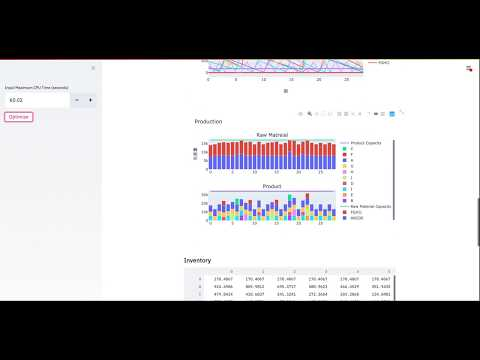

In [ ]:
#| echo: false
from IPython.display import Image, YouTubeVideo
YouTubeVideo("0li4ma3EYs8")

## はじめに

ここで論じるのは，需要量が期によって変動するときの
各期の生産量（もしくは発注量）ならびに在庫量を決定するためのモデル（動的ロットサイズ決定モデル）である．
発注量を決める古典モデルである経済発注量モデルは，サプライ・チェイン基本分析システム SCBASの，安全在庫、ロットサイズ、目標在庫（基在庫レベル）の設定関数 inventory_analysisで計算できる．
ここで考えるモデルは，経済発注量モデルにおける需要が一定という仮定を拡張し，期によって変動することを許したものである．

計画期間は有限であるとし，発注を行う際の段取り費用（もしくは生産費用）と
在庫費用のトレードオフをとることがモデルの主目的になる．

ロットサイズ決定は，タクティカルレベルの意思決定モデルであり，
与えられた資源（機械や人）の下で，活動をどの程度まとめて行うかを決定する．

一般に，生産や輸送は規模の経済性をもつ．
これをモデル化する際には，生産や輸送のための諸活動を行うためには「段取り」とよばれる準備活動が必要になると考える．
ロットサイズ決定とは，段取り活動を行う期を決定し，
生産・輸送を表す諸活動をまとめて行うときの「量」を決定するモデルである．

ロットサイズ決定問題は，古くから多くの研究が行われている問題であるが，
国内での（特に実務家の間での）認知度は今ひとつのようである．
適用可能な実務は，ERP（Enterprise Resource Planning）やAPS（Advanced Planning and Scheduling）などの処理的情報技術を導入しており，かつ
段取りの意思決定が比較的重要な分野である．
そのような分野においては，
ERPやAPSで単純なルールで自動化されていた部分に最適化を持ち込むことによって，
より現実的かつ効率的な解を得ることができる．
特に，装置産業においては，ロットサイズ決定モデルは，生産計画の中核を担う．

現在の我が国で販売されている生産スケジューラは，すべてルールに基づいたヒューリスティクスであり，いわゆる処理的情報技術に過ぎない．
ロットまとめの意思決定はタクティカルレベルであり，オペレーショナルレベルのスケジューリング最適化と同時に行うべきではない．
個々の意思決定レベルの最適化に基づき，情報のやりとりによって全体最適化を目指す必要があり，そのためには，広範囲の問題が解けるロットサイズ決定モデルが必須である．


In [ ]:
#| hide
# MOAI approach test
import numpy as np
np.random.seed(123)

T = 10
fixed_cost = 5
inv_cost = 1
lb, ub = 1, 10
max_iter = 10000
fixed = np.full(T, fill_value = fixed_cost, dtype=int) 
#fixed = np.random.randint(3,10,T) 
variable = np.zeros(T, dtype=int)
h =  np.full(T, fill_value=inv_cost, dtype=int) 
X = np.zeros((max_iter,T) )
y = np.zeros( (max_iter,T), dtype=int) 
obj = np.zeros(max_iter, dtype=int)
for iter in range(max_iter):
#for iter in range(1):
    #demand = X_test[316]
    demand = np.random.randint(lb,ub,T) 
    F = [9999999 for i in range(T)]
    prev = [-1 for i in range(T)]
    for i in range(T):
        if i == 0:
            cum = fixed[i] + variable[i] * demand[i]
        else:
            cum = F[i - 1] + fixed[i] + variable[i] * demand[i]

        cumh = 0
        for j in range(i, T):
            if cum <= F[j]: #同点の場合は，後から計算したものを優先
                F[j] = cum
                prev[j] = i
            # else:
            #     break
                
            if j == (T - 1):
                break
            cumh += h[j]
            cum += (variable[i] + cumh) * demand[j + 1]
            if (
                fixed[j + 1] + variable[j + 1] * demand[j + 1]
                < (variable[i] + cumh) * demand[j + 1]
            ):
                break
    #print("Optimal Value=", F[T - 1])
    obj[iter] = F[T - 1]
    t = T-1
    while t>=0:
        if prev[t] == t:
            y[iter,t]=1
            t -=1
        else:
            if y[iter,t] != 1: #t期に段取りをしていない場合には， その前の期に段取りを行う
                y[iter,prev[t]]=1
                t = prev[t]
            else: #t期に段取りをしている場合には， 前の期に移動
                t-=1
        #print(t, y[iter,t], prev[t])
        
    #print("demand=", demand, "setup=",y[iter], prev)
    X[iter] = demand

In [ ]:
#| hide
#https://scikit-learn.org/stable/modules/multiclass.html
# Support multiclass-multioutput:
# tree.DecisionTreeClassifier
# tree.ExtraTreeClassifier
# ensemble.ExtraTreesClassifier
# neighbors.KNeighborsClassifier
# neighbors.RadiusNeighborsClassifier
# ensemble.RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
classifier = RandomForestClassifier() #DecisionTreeClassifier() #RandomForestClassifier(), ExtraTreesClassifier()
clf = MultiOutputClassifier(classifier).fit(X_train, y_train)
yhat = clf.predict(X_test)
accuracy_score(y_test, yhat)

0.949

In [ ]:
#| hide
data = np.concatenate([X,y], axis=1)
#data.shape, X.shape, y.shape
df = pd.DataFrame(data, columns=[f"demand_{t}" for t in range(T)] + [f"setup_{t}" for t in range(T)])
df.to_csv(f"data_{T}.csv")

In [ ]:
#| hide
p = clf.predict_proba(X_test) 
# for i in p:
#     print(i)
#p[3]
#len(p[1]
for t in range(T):
    print(p[t][0][0], end=", ")

1.0, 0.99, 0.0, 0.98, 0.01, 0.01, 0.0, 0.91, 0.06, 0.86, 

In [ ]:
#| hide
def compute_cost(setup,demand):
    cost = 0
    cum_inv = 0
    for t in range(T-1,-1,-1):
        if setup[t]==1:
            cost+= fixed_cost
            cum_inv = 0
        else:
            cum_inv += int(demand[t])
            cost+= inv_cost*cum_inv
    return cost

from scipy.stats.mstats import gmean
ratio = []
for i in range(len(X_test)):
    opt_cost = compute_cost(y_test[i], X_test[i])
    app_cost = compute_cost(yhat[i], X_test[i])
    #if app_cost/opt_cost < 1.0:
    #print(app_cost/opt_cost)
    ratio.append( app_cost/opt_cost )
    #print(yhat[i], y_test[i], X_test[i], i)
print(gmean(ratio))

1.0015281130968765


In [ ]:
#|hide
#MIP learn
from sklearn.neighbors import NearestNeighbors

k = 5
thres_0, thres_1 = 0.1, 0.9 #0,1に固定する閾値
nn = NearestNeighbors(metric="manhattan")
nn.fit(X_train) #訓練

ratio = []
for i in range(len(X_test)):
#for i in range(316,317):
    distance, idx = nn.kneighbors(X_test[i].reshape((1,T)), n_neighbors=k) #近い方からk個
    y_sum = np.zeros(T)
    for j in idx:
        y_sum = y_sum + y_train[j]
    prob = y_sum.sum(axis=0)/k
    
    #閾値で固定, MIPで解く
    model = Model()
    x, setup, I ={}, {}, {}
    for t in range(T):
        x[t] = model.addVar(name=f"x({t})")
        #variable fixing
        if prob[t]>=thres_1:
            LB = UB = 1.
        elif prob[t]<=thres_0:
            LB = UB = 0.
        else:
            LB = 0.
            UB = 1.
        setup[t] = model.addVar(lb=LB, ub=UB, vtype="B", name=f"setup({t})")
        I[t] = model.addVar(name=f"I({t})")
    model.update()
    
    I[-1] = 0
    M = X_test[0].sum()
    for t in range(T):
        model.addConstr( I[t-1]+x[t]== X_test[i][t] + I[t] )
    for t in range(T):
        model.addConstr( x[t]<= M*setup[t] )
    model.setObjective(quicksum(fixed[t]*setup[t] + h[t]*I[t] for t in range(T)), GRB.MINIMIZE)
    #model.Params.OutputFlag=False
    max_cpu = 600
    solver = PULP_CBC_CMD(timeLimit=max_cpu, msg=0) 
    model.optimize(solver)
    app_cost = model.ObjVal
    opt_cost = compute_cost(y_test[i], X_test[i])
    if app_cost/opt_cost < 1.0:
        print(app_cost, opt_cost)
        print(app_cost/opt_cost, i)
        for t in setup:
            print(setup[t].X, I[t].X, X_test[316][t])
        break
    ratio.append( app_cost/opt_cost )
    
print("幾何平均=", gmean(ratio))

幾何平均= 1.0


In [ ]:
#| hide

from fastai.tabular.all import *
dls = TabularDataLoaders.from_csv(
    f"data_{T}.csv",
    y_names= [f"setup_{t}" for t in range(T)], 
    y_block= CategoryBlock(),
    cont_names=[f"demand_{t}" for t in range(T)], 
    #procs=[Normalize],
)
learn = tabular_learner(dls, wd=0.001, layers=[1000,500,300], n_out=T, metrics=[accuracy_multi], loss_func = BCEWithLogitsLossFlat() ) #BCE=Binary Cross Entropy
learn.fit_one_cycle(20, 0.0001)
learn.predict(df.iloc[0, :T])

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.562707,0.481287,0.214050,00:02
1,0.387769,0.327915,0.158150,00:01
2,0.280342,0.235192,0.122250,00:01
3,0.184036,0.110912,0.122350,00:01
4,0.042442,-0.042650,0.133200,00:01
5,-0.195864,-0.334150,0.145850,00:01
6,-0.517225,-0.669518,0.150500,00:01
7,-0.899119,-1.053587,0.164250,00:01
8,-1.300842,-1.449695,0.179650,00:01
9,-1.702324,-1.844679,0.206700,00:01


(   demand_0  demand_1  demand_2  demand_3  demand_4  demand_5  demand_6  \
 0       3.0       3.0       7.0       2.0       4.0       7.0       2.0   
 
    demand_7  demand_8  demand_9  setup_0  setup_1  setup_2  setup_3  setup_4  \
 0       1.0       2.0       1.0      0.0      0.0      0.0      0.0      0.0   
 
    setup_5  setup_6  setup_7  setup_8  setup_9  
 0      0.0      0.0      0.0      0.0      0.0  ,
 tensor([False, False, False, False, False, False, False, False, False, False]),
 tensor([1.7453e-03, 2.5860e-07, 4.4674e-01, 4.3325e-09, 1.2900e-01, 1.6051e-01,
         1.5687e-06, 9.5012e-07, 3.0271e-02, 4.3284e-08]))

## データ

### 読み込みと生成

In [ ]:
prod_df = pd.read_csv(folder + "lotprod.csv",index_col=0)
prod_df.set_index("name", inplace=True)
production_df = pd.read_csv(folder + "production.csv",index_col=0)
bom_df = pd.read_csv(folder + "bomodel.csv", index_col =0)
resource_df = pd.read_csv(folder + "resource.csv", index_col=0)
plnt_demand_df = pd.read_csv(folder+"plnt-demand.csv")
demand = pd.pivot_table(plnt_demand_df, index= "prod", columns ="period",  values="demand", aggfunc=sum)

### 品目データ

製品や半製品や部品や原材料をあわせて品目とよぶ． 
データ項目は以下の通り．

- name: 名称
- inv_cost: （工場における）在庫費用
- safety_inventory: 安全在庫量（在庫量の下限値）
- initial_inventory: 初期在庫量
- target_inventory: 目標在庫量（在庫量の上限値）

In [ ]:
prod_df

,inv_cost,safety_inventory,initial_inventory,target_inventory
name,,,,
A,0.005769,38.636429,401.0,763.398459
B,0.005769,37.812572,395.0,753.503381
C,0.005769,22.971393,373.0,723.295128
D,0.005769,17.463825,323.0,630.222614
E,0.005769,200.161342,934.0,1668.384758
F,0.005769,33.532552,385.0,737.729494
G,0.005769,41.214374,450.0,859.171178
H,0.005769,96.322978,498.0,901.348857
I,0.005769,20.535360,333.0,645.835288


### 生産データ

工場における各品目の生産データを保管する． データ項目は以下の通り．

- name: 品目名
- ProdTime: 品目1単位の生産時間
- SetupTime: 品目の段取り時間
- ProdCost: 品目1単位の生産費用
- SetupCost: 品目の段取り費用

In [ ]:
production_df

,name,ProdTime,SetupTime,ProdCost,SetupCost
0,A,1,3752,218,18873
1,B,1,6193,153,19454
2,C,1,5206,203,18008
3,D,1,6628,144,10289
4,E,1,5539,213,10470
5,F,1,4028,170,12393
6,G,1,4395,208,10508
7,H,1,5289,171,11959
8,I,1,6635,284,11938
9,J,1,4275,282,12590


### 部品展開表（枝）データ

どの品目（親品目）がどの品目（子品目）から製造されるかを表すデータ．データ項目は，以下の通り．

- child: 子品目（枝の出発点）
- parent: 親品目（枝の到着点）
- units: 親品目1単位を製造するために必要な子品目の数

In [ ]:
bom_df

,child,parent,units
0,ABCDE,A,1
1,ABCDE,B,1
2,ABCDE,C,1
3,ABCDE,D,1
4,ABCDE,E,1
5,FGHIJ,F,1
6,FGHIJ,G,1
7,FGHIJ,H,1
8,FGHIJ,I,1
9,FGHIJ,J,1


### 需要データ

各（最終）品目の期ごとの需要量を保管する．

In [ ]:
demand

period,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
prod,,,,,,,,,,,,,,,,,,,,,
A,12607,9700,10743,12361,10971,11835,11457,12331,10895,11739,...,16728,16814,16545,17139,16092,15550,16085,17367,16447,15288
B,11615,11448,10511,10698,11532,11694,10784,12906,11695,11695,...,13776,15588,16452,16163,14370,17795,14495,14654,13622,16490
C,4673,4545,3978,4551,3376,4471,4128,4299,4731,4072,...,6362,5667,6067,5630,5553,6329,6384,6816,6113,6151
D,523,490,491,480,538,489,529,526,534,568,...,756,716,696,761,760,682,771,733,694,750
E,47705,49913,50755,50712,47705,43462,49057,46509,55423,52030,...,67193,60003,65447,73008,74761,69651,75255,70322,70567,71030
F,8026,7661,8048,7967,7177,7946,8141,7524,7801,8261,...,9664,10244,10250,10294,9653,10567,11465,11614,10023,11288
G,10293,9586,10591,8613,9825,10961,10291,10687,10027,9467,...,15540,13173,14380,14110,15172,16715,15323,14382,16271,15819
H,25189,24967,24478,23431,26105,23759,24443,22857,24239,23478,...,36093,35980,36019,37020,34913,34591,37014,31564,35839,37686
I,1755,1664,1579,1582,1618,1591,1729,1678,1582,1585,...,2097,2179,1984,2268,2382,2331,2296,1808,2036,2171


### 資源データ

資源の使用可能量上限（容量；使用可能時間）を規定する．データ項目は，以下の通り．

- name: 資源名
- period: 期
- capacity: 使用可能量上限


In [ ]:
resource_df.head()

,name,period,capacity
0,Res0,0,102239.854167
1,Res0,1,102239.854167
2,Res0,2,102239.854167
3,Res0,3,102239.854167
4,Res0,4,102239.854167


## 標準モデルの定式化


## 多段階動的ロットサイズ決定モデル
Pochet--Wolsey 1991 Management Science Vol. 37 53--67 参照

ここでは，多段階にわたって製造を行うときのロットサイズ決定問題を考える．

### 標準定式化

集合

-  $\{1..T\}$: 期間の集合
-  $P$ : 品目の集合（完成品と部品や原材料を合わせたものを「品目」と定義する。）
-  $K$ : 生産を行うのに必要な資源（機械，生産ライン，工程などを表す）の集合
-  $P_k$ : 資源 $k$ で生産される品目の集合
-  $Parent_p$ : 部品展開表における品目（部品または材料）$p$ の親品目の集合．言い換えれば，品目 $p$ から製造される品目の集合

パラメータ

-  $T$: 計画期間数；期を表す添え字を $1,2,\cdots,t,\cdots,T$ と記す．
-  $f_t^p$ : 期 $t$ に品目 $p$ に対する段取り替え（生産準備）を行うときの費用（段取り費用）
-  $g_t^p$ : 期 $t$ に品目 $p$ に対する段取り替え（生産準備）を行うときの時間（段取り時間）
-  $c_t^p$ : 期 $t$ における品目 $p$ の生産変動費用
-  $h_t^p$ : 期 $t$ から期 $t+1$ に品目 $p$ を持ち越すときの単位あたりの在庫費用
-  $d_t^p$ : 期 $t$ における品目 $p$ の需要量
-  $\phi_{pq}$ : $q \in Parent_p$ のとき， 品目 $q$ を $1$ 単位製造するのに必要な品目 $p$ の数 （$p$-units）； ここで， $p$-unitsとは，品目 $q$ の $1$単位と混同しないために導入された単位であり， 品目 $p$ の $1$単位を表す．$\phi_{pq}$ は，部品展開表を有向グラフ表現したときには，枝の重みを表す．
-  $M_t^k$ : 期 $t$ における資源 $k$ の使用可能な生産時間の上限． 定式化では，品目 $1$単位の生産時間を $1$単位時間になるようにスケーリングしてあるものと仮定しているが， プログラム内では単位生産量あたりの生産時間を定義している．
-  $UB_t^p$ : 期 $t$ における品目 $p$ の生産時間の上限．
   品目 $p$ を生産する資源が $k$ のとき，資源の使用可能時間の上限 $M_t^k$ から段取り替え時間 $g_t^p$ を減じたものと定義される．

変数

-  $x_t^p$（x）: 期 $t$ における品目 $p$ の生産量
-  $I_t^p$（inv） : 期 $t$ における品目 $p$ の在庫量
-  $y_t^p$（y）: 期 $t$ に品目 $p$ に対する段取りを行うとき $1$， それ以外のとき $0$ を表す $0$-$1$ 変数


上の記号を用いると、多段階ロットサイズ決定モデルは，以下のように定式化できる．

$$
\begin{array}{ l l l }
minimize & \sum_{t=1}^T \sum_{p \in P} \left( f_t^p y_t^p + c_t^p x_t^p + h_t^p I_t^p \right) &           \\
s.t. &  \ \ I_{t-1}^p +x_t^p  = d_t^p+ \sum_{q \in Parent_p} \phi_{pq} x_t^q  +I_t^p & \forall p \in P, t=1,\cdots,T  \\
            &  \sum_{p \in P_k} x_t^p  +\sum_{p \in P_k} g_t^p y_t^p \leq M_t^k    & \forall k \in K, t=1,\cdots,T \\
            &  x_t^p  \leq UB_t^p y_t^p     & \forall p \in P, t=1,\cdots,T  \\
            &  I_0^p =0               & \forall p \in P                          \\
            &  x_t^p,I_t^p \geq 0         & \forall  p \in P, t=1,\cdots,T  \\
            &  y_t^p \in \{0,1\}   & \forall p \in P, t=1,\cdots,T 
\end{array}
$$


上の定式化で，最初の制約式は，各期および各品目に対する在庫の保存式を表す．
より具体的には，品目 $p$ の期 $t-1$ からの在庫量 $I_{t-1}^p$ と生産量 $x_t^p$ を加えたものが，
期 $t$ における需要量 $d_t^p$，次期への在庫量 $I_t^p$，
および他の品目を生産するときに必要な量 $\sum_{q \in Parent_p} \phi_{pq} x_t^q$ の和に等しいことを表す． 

2番目の制約は， 各期の生産時間の上限制約を表す． 定式化ではすべての品目の生産時間は，
$1$ 単位あたり$1$ 時間になるようにスケーリングしてあると仮定していたが，実際問題のモデル化の際には，
品目 $p$ を $1$ 単位生産されるときに，資源 $k$ を使用する時間 $a_{k}^p$ を用いた方が汎用性がある．

3番目の式は，段取り替えをしない期は生産できないことを表す．

また，以下の強化式を追加すると，高速化する可能性がある．
$$
 x_t^p \leq d_t^p y_t^p +I_y^p  \ \ \ \forall  p \in P, t=1,\cdots,T\forall  p \in P, t=1,\cdots,T
$$


### エシェロン在庫を用いた定式化

品目間の親子関係だけでなく，先祖（部品展開表を表す有向グラフを辿って到達可能な品目の集合）を導入しておく．

集合

- $Ancestor_{p}$: 品目 $p$ の先祖の集合． 親子関係を表す有向グラフを辿って到達可能な点に対応する品目から構成される集合． 品目 $p$ 自身は含まないものとする．

パラメータ

- $\rho_{pq}$: $q \in Ancestor_p$ のとき，品目 $q$ を $1$ 単位生産するのに必要な品目 $p$ の量
- $H_t^p$: 期 $t$ における品目 $p$ のエシェロン在庫費用； 品目 $p$ を生産することによって得られた付加価値に対する在庫費用を表す。品目 $p$ を製造するのに必要な品目の集合を $Child_p$ としたとき，以下のように定義される．
$$
 H_t^p =h_t^p -\sum_{q \in Child_p} h_t^q \phi_{qp}
$$

変数
- $E_{t}^p$:  期 $t$ における品目 $p$ のエシェロン在庫量；自分と自分の先祖の品目の在庫量を合わせたものであり， 以下のように定義される．
$$
 E_t^p = I_t^p +\sum_{q \in Ancestor_p} \rho_{pq} I_t^q
$$ 

上の記号を用いると，エシェロン在庫を用いた多段階ロットサイズ決定モデルの定式化は，以下のようになる．
$$
\begin{array}{ l l l }
minimize & \sum_{t=1}^T \sum_{p \in P} \left( f_t^p y_t^p + c_t^p x_t^p + H_t^p E_t^p \right) &           \\
s.t. & \ \ E_{t-1}^p +x_t^p - E_t^p = d_t^p + \sum_{q \in Ansestor_p} \rho_{pq} d_t^q  & \forall p \in P, t=1,\cdots,T  \\
            &  \sum_{p \in P_k} x_t^p  +\sum_{p \in P_k} g_t^p y_t^p \leq M_t^k    & \forall  k \in K, t=1,\cdots,T  \\
            & E_t^p \geq   \sum_{q \in Parent_p} \phi_{pq} E_t^q    & \forall p \in P, t=1,\cdots,T  \\
            &  x_t^p  \leq UB_t^p  y_t^p     & \forall p \in P, t=1,\cdots,T  \\
            &  E_0^p =0               & \forall p \in P                          \\
            &  x_t^p,E_t^p \geq 0         & \forall  p \in P, t=1,\cdots,T  \\
            &  y_t^p \in \{0,1\}   & \forall p \in P, t=1,\cdots,T 
\end{array}
$$

上の定式化で，最初の制約は，各期および各品目に対するエシェロン在庫の保存式を表す．
より具体的には，品目 $p$ の期 $t-1$ からのエシェロン在庫量 $E_{t-1}^p$ と生産量 $x_t^p$ を加えたものが，
期 $t$ における品目 $p$ の先祖 $q$ の需要量を品目 $p$ の必要量に換算したものの合計 $\sum_{q \in Ansestor_p} \rho_{pq} d_t^q$ と、
自身の需要量 $d_{t}^p$ と、次期へのエシェロン在庫量 $E_t^p$ の和に等しいことを表す． 
2番目の制約は，各期の生産時間の上限制約を表す．
3番目の制約は，各品目のエシェロン在庫量が，その親集合の品目のエシェロン在庫量の合計以上であること（言い換えれば実需要量が負にならないこと）を規定する．
4番目の制約は，段取り替えをしない期は生産できないことを表す．

この定式化は1段階モデルと同じ構造をもつので、強化式を加えたり、施設配置定式化のような強い定式化に変形することが可能である。


以下のプログラムでは、実在庫量の上下限制約を付加している。エシェロン在庫モデルにおける3番目の制約のスラック変数が、実在庫量になっているので、
制約を以下のように書き換えた後で、実在庫量に対する上下限制約を付加すれば良い。

$$
E_t^p + I_t^p  = \sum_{q \in Parent_p} \phi_{pq} E_t^q  \ \ \ \forall p \in P, t=1,\cdots,T 
$$

### 施設配置定式化

ここでは，オリジナルと定式化と同じ $O(T)$ 個の $0$-$1$ 変数を用いて，より強い定式化を導く．
簡単のため1段階モデルを考える。品目を表す添え字 $p$ を付加し、在庫をエシェロン在庫に置き換えれば、多段階にも使うことができる。

我々の想定しているロットサイズ決定問題では品切れは許さないので，
期 $t$ の需要は，期 $t$ もしくはそれ以前の期で生産された量でまかなわれなければならない．
そこで，期 $t$ の需要のうち，期 $s (s \leq t)$ で生産した量によってまかなわれた比率を表す変数 $X_{st}$ を導入する．

$X_{st}$ が $1$ のとき，期　$t$の需要量 $d_t$ が，期 $s$ で生産され，期 $t$ まで在庫される．
需要 $1$　単位あたりの変動費用は，生産変動費用 $c_s$ と在庫費用 $\sum_{\ell=s}^{t-1} h_{\ell}$ の和になるので，
$X_{st}$ の係数 $CH_{st}$ は，以下のように定義される．
$$
 CH_{st}= \left( c_s +\sum_{\ell=s}^{t-1} h_{\ell} \right) d_t 
$$

すべての需要は満たされなければならず， また $X_{st} >0$ のときには期 $s$ で生産しなければならないので， $y_s=1$ となる．
ここで，$y_t$ はオリジナルの定式化における $0$-$1$ 変数で，
期 $t$ に生産をするときに $1$，それ以外のとき $0$ を表すことを思い起こされたい．
よって，以下の定式化を得る．

$$
 \begin{array}{ l l l }
  minimize & \sum_{s t: s \leq t} CH_{st} X_{st} + \sum_{t} f_t y_t &        \\
  s.t.   & \ \ \sum_{s=1}^t X_{st}=1    & \forall  t=1,\cdots,T  \\
                &  X_{st} \leq y_s         & \forall s \leq t, t=1,\cdots,T  \\
                &  X_{st} \geq 0           & \forall s \leq t, t=1,\cdots,T \\
                & y_t \in \{0,1\}          & \forall t=1,\cdots,T  
 \end{array}
$$


この定式化は，期を表す点を需要地点（マーケット）ならびに施設（倉庫）の配置可能地点ととらえると，
施設配置問題に類似した問題になるので，施設配置定式化（facility location formulation）とよばれる．

オリジナルの定式化の変数との関係は以下のようになる。

各期の生産量：
$$
x_s = \sum_{t=s}^T d_t X_{st} 
$$

在庫量：
$$
 I_t = \sum_{i=1}^t ( x_i -d_i ) 
$$

この関係を用いれば、オリジナルの定式化に含まれている付加制約を記述することができる。

他にも、生産をする際のロットサイズが固定されている場合（フル容量生産）に対しては、別の強化された定式化が可能である。
また、順序依存の段取りや複数の生産資源制約や生産ラインへの割り当てを考慮した定式化も可能であるが、問題の規模が大きくなると計算が困難になる。
実際問題の制約に応じて、カスタマイズされた定式化を行うことが望ましい。


## 多モードロットサイズ決定モデルの定式化

### 小バケットモデル

各期の各モード（ラインを想定）では，1つの品目を生産できると仮定した場合を考える．これは，高々2つの品目を生産可能な場合に拡張できる． 

集合

-  $\{1..T\}$: 期間の集合
-  $P$ : 品目の集合（完成品と部品や原材料を合わせたものを「品目」と定義する。）
-  $K$ : 生産を行うのに必要な資源（機械，生産ライン，工程などを表す）の集合
-  $M_p$: 品目 $p$ のモードの集合（すべてのモードの集合は $M$）
-  $PM_k$ : 資源 $k$ で生産される品目とモードの対の集合

パラメータ

-  $T$: 計画期間数；期を表す添え字を $1,2,\cdots,t,\cdots,T$ と記す．
-  $f_{tm}^p$ : 期 $t$ に品目 $p$ をモード $m$ で段取り替え（生産準備）を行うときの費用（段取り費用）
-  $g_{tm}^p$ : 期 $t$ に品目 $p$ をモード $m$ で段取り替え（生産準備）を行うときの時間（段取り時間）
-  $c_{tm}^p$ : 期 $t$ における品目 $p$ のモード $m$ での生産変動費用
-  $\tau_{tm}^p$: 期 $t$ における品目 $p$ のモード $m$ での単位生産時間
-  $h_t^p$ : 期 $t$ から期 $t+1$ に品目 $p$ を持ち越すときの単位あたりの在庫費用
-  $d_t^p$ : 期 $t$ における品目 $p$ の需要量
-  $U_t^k$ : 期 $t$ における資源 $k$ の使用可能な生産時間の上限． 
-  $UB_t^{kp}$ : 期 $t$ における品目 $p$ の生産時間の上限．
   品目 $p$ を生産する資源が $k$ のとき，資源の使用可能時間の上限 $U_t^k$ から段取り替え時間 $g_t^p$ を減じたものと定義される．

変数

-  $x_{tm}^p$: 期 $t$ における品目 $p$ のモード $m$ における生産量
-  $I_t^p$ : 期 $t$ における品目 $p$ の在庫量（ただし $t=0$ のときには初期在庫，$t=T$ のときには最終在庫を表すパラメータとする．）
-  $y_{tm}^p$: 期 $t$ に品目 $p$ をモード $m$ で生産を行うとき $1$， それ以外のとき $0$ を表す $0$-$1$ 変数（ただし $t=0$ のときには初期における段取り状態を表すパラメータとする． また，$t=0$ のときには，1つの品目の段取り状態になっていないといけない．）
-  $z_{tm}^p$: 期 $t$ に品目 $p$ をモード $m$ で段取りを開始するとき $1$， それ以外のとき $0$ を表す $0$-$1$ 変数
-  $w_{tm}^p$: 期 $t$ に品目 $p$ をモード $m$ で段取りを終了するとき $1$， それ以外のとき $0$ を表す $0$-$1$ 変数

上の記号を用いると、小バケットロットサイズ決定モデルは，以下のように定式化できる．

$$
\begin{array}{ l l l }
minimize & \sum_{t=1}^T \sum_{p \in P} \sum_{m \in M_p} \left( f_{tm}^p z_{tm}^p + c_{tm}^p x_{tm}^p + h_t^p I_t^p \right) &           \\
s.t. &  \ \ I_{t-1}^p + \sum_{m \in M_p} x_{tm}^p  = d_t^p+ I_t^p & \forall p \in P, t=1,\cdots,T  \\
            &  \sum_{(p,m) \in PM_k}  ( \tau_{tm}^p x_t^p + g_{tm}^p z_{tm}^p )  \leq U_t^k    & \forall k \in K, t=1,\cdots,T \\
            &  x_{tm}^p  \leq UB_t^p y_{tm}^p     & \forall p \in P, t=1,\cdots,T  \\
            & \sum_{p} y_{tm}^p = 1  & \forall m \in M, t=1,\cdots,T \\
            & z_{tm}^p \leq y_{tm}^p   & \forall  p \in P, m \in M_p, t=1,\cdots,T  \\
            & z_{tm}^p- w_{t-1,m}^p = y_{tm}^p - y_{t-1,m}^p  & \forall  p \in P, m \in M_p, t=1,\cdots,T  \\
            &  I_0^p =0               & \forall p \in P                          \\
            &  x_{tm}^p \geq 0         & \forall  p \in P, m \in M_p, t=1,\cdots,T  \\
            &  I_t^p \geq 0             & \forall  p \in P, t=1,\cdots,T  \\
            &  y_{tm}^p, z_{tm}^p, w_{tm}^p   \in \{0,1\}   & \forall  p \in P, m \in M_p, t=1,\cdots,T
\end{array}
$$

また，以下の強化式を追加すると，高速化する可能性がある．
$$
 y_{t-1,m}^p + z_{tm}^p  + \sum_{q \neq p: m \in M_q} (y_{tm}^q - z_{t,m}^q ) \leq 1  \ \ \ \forall  p \in P, m \in M_p, t=1,\cdots,T 
$$

これは， 以下の3つが同時に発生しないことを表す．

1. 期 $t-1$ に品目 $p$ が段取り状態である．
2. 期 $t$ に品目 $p$ が段取りを開始する．
3. $p$ 以外の品目 $q$ が期 $t$ に段取りを開始する以外で段取り状態にある．（$y_{tm}^q=1$ でかつ $z_{t,m}^q=0$ である．）

### 高々2つの品目が生産可能と仮定した小バケットモデル

段取りに関する部分を以下を変更する．
$$
\begin{array}{ l l l }
            & \sum_{p} (y_{tm}^p -z_{tm}^p ) = 1  & \forall m \in M, t=1,\cdots,T \\
            & z_{tm}^p +z_{t-1,n}^p \leq y_{tm}^p   & \forall  p \in P, m \in M_p, t=1,\cdots,T  
\end{array}
$$

最初の式は，段取り状態で段取り開始でない品目（前の期からの段取りを引き継いでいる品目）は，1つであることを表す．
次の式は，期 $t$ もしくは $t-1$ に段取り開始をしたならば，期 $t$ は段取り状態になっていることを表し，同時に2期連続で段取り開始できないことを表す．


また，以下の強化式を追加すると，高速化する可能性がある．
$$
 y_{tm}^p + \sum_{q \neq p:  m \in M_q} (y_{t+1,m}^q - z_{t+1,m}^q -z_{tm}^q ) \leq 1  \ \ \ \forall  p \in P, m \in M_p, t=1,\cdots,T 
$$

これは，品目 $p$ が期 $t$ に段取り状態になっている場合は，それ以外の品目 $q$ が期 $t+1$ に段取り状態で，かつ期 $t+1$ でも $t$ でも段取り開始をしていないことが不可能であることを規程する．


In [ ]:
#| include: false
prod_df = pd.read_csv(folder + "Prod_with_inventory.csv", index_col="name")
#prod_df = pd.read_csv(folder + "Prod.csv", index_col=0)
prod_df.head()

,index,weight,volume,cust_value,dc_value,plnt_value,fixed_cost,average_demand,standard_deviation,inv_cost,lot_size,safety_inventory,target_inventory,initial_inventory
name,,,,,,,,,,,,,,
A,0,2,0,7,1,1,14,11471.090909,749.533188,0.005753,7471.678242,1236.729760,8708.408003,4972.0
B,1,5,0,5,1,1,14,11194.909091,760.846897,0.005753,7381.184926,1255.397379,8636.582305,4945.0
C,2,1,0,5,1,1,19,4252.181818,302.641702,0.005753,5299.495116,499.358809,5798.853925,3149.0
D,3,3,0,5,1,1,17,517.363636,20.506097,0.005753,1748.534451,33.835059,1782.369511,908.0
E,4,1,0,10,1,1,18,49448.000000,3426.639462,0.005753,17589.860716,5653.955112,23243.815827,14448.0


In [ ]:
#需要の生成 
T = 24 
yearly_ratio = [1.0 + np.sin(i)*0.5 for i in range(13)] 
dem, prod, month = [], [], [] 
try:
    prod_df.reset_index(inplace=True)
except:
    pass
for row in prod_df.itertuples():
    mu, sigma  = row.average_demand, row.standard_deviation  #monthly demand and std (original average is weekly) 
    for t in range(T):
        dem.append( int(yearly_ratio[t//12]* random.gauss(mu,sigma)) )
        prod.append(row.name)
        month.append(t)
plnt_demand_df = pd.DataFrame({"prod":prod, "period":month, "demand": dem})
plnt_demand_df.to_csv(folder+"plnt-demand.csv")
plnt_demand_df.head()
#print("T=",T)

,prod,period,demand
0,A,0,11790
1,A,1,12295
2,A,2,12417
3,A,3,12506
4,A,4,11648


In [ ]:
try:
    prod_df.set_index("name",inplace=True)
except:
    pass

#２段階モデルを仮定；各段階には１つの資源制約と仮定
num_stages = 2
maintenance_cycle = 100 #資源が使用不可になる周期；この数で割り切れると休止
#num_resources = [2,3]
#assert num_stages == len(num_resources) #段階数と資源数のリストの長さは同じであることの確認

prod_time_bound = (1,1)
setup_time_bound =(3600,7200)
prod_cost_bound = (100,300)
setup_cost_bound =(10000,20000)

units_bound =(1,1)

num_parents = 5  # 1つの子品目から生成される親品目の数；distribution型の生産工程を仮定
products = list(prod_df.index)
num_prod = len(products)

#原材料リストを生成
raw_material_name=""
raw_materials = [] 
for i,p in enumerate(prod_df.index):
    raw_material_name += str(p)
    if (i+1)%num_parents == 0 or i==len(prod_df)-1:
        #print(i,p, raw_material_name)
        raw_materials.append(raw_material_name)
        raw_material_name =""
#親子関係を定義
parent = defaultdict(list)
child = {}
for r in raw_materials:
    parent[r] = list(r)
    for p in parent[r]:
        child[p] = r

#生産工程の容量を計算
average_demand = plnt_demand_df.demand.sum()/T
print(average_demand)

188868.375


In [ ]:
cycle_time= 4
capacity = (average_demand*prod_time_bound[1]+setup_time_bound[1]*num_prod/cycle_time)

print("capacity=",capacity)
#資源データフレーム
#期ごとに容量が変化するモデル
#print(capacity)
name_, period_, capacity_ = [], [], []
for s in range(num_stages):
    for t in range(T):
        name_.append( f"Res{s}")
        period_.append(t)
        if (t+1) % maintenance_cycle == 0:
            capacity_.append( 0 )
        else:
            if s ==0:
                capacity_.append( capacity/2 )
            else:
                capacity_.append( capacity)
resource_df = pd.DataFrame(data={"name": name_, "period": period_, "capacity": capacity_})

#部品展開表のデータフレーム生成
bom_df = pd.DataFrame(data={"child": [child[p] for p in products],
                         "parent": products,
                         "units": [random.randint(units_bound[0], units_bound[1]) for i in range(num_prod)]
                        })

#生産情報データフレーム生成
items = products+raw_materials
num_item = len(items)
production_df = pd.DataFrame(data={"name": items,
                             "ProdTime": [random.randint(prod_time_bound[0], prod_time_bound[1]) for i in range(num_item)],
                             "SetupTime": [random.randint(setup_time_bound[0], setup_time_bound[1]) for i in range(num_item)],
                             "ProdCost": [random.randint(prod_cost_bound[0], prod_cost_bound[1]) for i in range(num_item)],
                             "SetupCost": [random.randint(setup_cost_bound[0], setup_cost_bound[1]) for i in range(num_item)]
                             })
production_df.set_index("name", inplace=True)
production_df.reset_index(inplace=True)
production_df.to_csv(folder+"production.csv")
bom_df.to_csv(folder+"bomodel.csv")
resource_df.to_csv(folder+"resource.csv")

capacity= 206868.375


In [ ]:
#lotsize用のprodデータ作成
#inv_cost: Optional[float] = Field(description="工場における在庫費用")
#safety_inventory: Optional[float] = Field(description="安全在庫量（最終期の目標在庫量）")
#initial_inventory: Optional[float] = Field(description="初期在庫量")
#target_inventory

prod_df.reset_index(inplace=True)
name = prod_df.name.to_list()
inv_cost = prod_df.inv_cost.to_list()
safety_inventory = prod_df.safety_inventory.to_list()
initial_inventory = prod_df.initial_inventory.to_list()
target_inventory = prod_df.target_inventory.to_list()

name.extend(raw_materials)
inv_cost.extend( [0.002 for i in range(len(raw_materials))])
safety_inventory.extend([sum(safety_inventory[:num_parents]),sum(safety_inventory[num_parents:])] )
initial_inventory.extend([sum(initial_inventory[:num_parents]),sum(initial_inventory[num_parents:])] )
target_inventory.extend([sum(target_inventory[:num_parents]),sum(target_inventory[num_parents:])] )

prod_df = pd.DataFrame({"name":name, "inv_cost":inv_cost,"safety_inventory":safety_inventory,"initial_inventory":initial_inventory,"target_inventory":target_inventory})
prod_df.to_csv(folder+"lotprod.csv")

## ロットサイズ決定問題を解く関数 lotsizing

2段階モデルを仮定し、最初の段階（原材料生成工程）における資源名を Res0、次の段階（完成品生産工程）における資源名をRes1とする。

原材料の在庫は許さないものとする。

親品目は子品目１単位から生成される。

引数：

- prod_df : 品目データフレーム
- production_df : 生産情報データフレーム
- bom_df : 部品展開表データフレーム
- demand : （期別・品目別の）需要を入れた配列（行が品目，列が期）
- resource_df : 資源データフレーム

返値：
- model : ロットサイズ決定モデルのオブジェクト（最適解の情報も mode.__data に含む）; 最適化の状態は model.Status
- T : 計画期間数

In [ ]:
#| export
def lotsizing(prod_df, production_df, bom_df, demand, resource_df, max_cpu = 10, solver = "CBC"):
    """
    ロットサイズ決定問題を解く関数
    """
    
    #原材料と完成品の抽出
    if bom_df is not None:
        raw_materials = set(bom_df["child"])
        products = set(bom_df["parent"])
        items = raw_materials | products
    else:
        prod_df.reset_index(inplace=True)
        products = set(prod_df.name)
        items = products
        prod_df.set_index("name", inplace=True)
    #計画期間の数の抽出
    _, T = demand.shape
    #print("T=", T)

    #資源の容量の抽出
    M = {}
    for row in resource_df.itertuples():
        M[row.name, row.period] = row.capacity

    #親子関係の辞書を作成
    parent = defaultdict(set)
    phi = defaultdict(float) #qを１単位生産するために必要なpのunit数
    if bom_df is not None:
        for row in bom_df.itertuples():
            parent[row.child].add( row.parent )
            phi[row.child,row.parent] = row.units

    model = Model()
    x, I, y = {}, {}, {}
    slack, surplus = {}, {}
    Ts = range(0, T)
    
    if bom_df is not None:
        for i, p in enumerate(raw_materials):
            for t in Ts:
                x[t, p] = model.addVar(name=f"x[{p},{t}]")
                I[t, p] = model.addVar(name=f"I[{p},{t}]", ub=float(prod_df.target_inventory[p]))
                y[t, p] = model.addVar(name=f"y[{p},{t}]", vtype="B")
                slack[t, p] = model.addVar(name=f"slack[{p},{t}]")
                surplus[t, p] = model.addVar(name=f"surplus[{p},{t}]")
            I[-1, p] =   float(prod_df.initial_inventory[p]) #初期在庫
            I[T-1,p] =   float(prod_df.safety_inventory[p])  #最終期の在庫量

    for i, p in enumerate(products):
        for t in Ts:
            # print(demand[i][t])
            x[t, p] = model.addVar(name=f"x[{p},{t}]")
            I[t, p] = model.addVar(name=f"I[{p},{t}]", lb=float(
                prod_df.safety_inventory[p]), ub=float(prod_df.target_inventory[p]))
            y[t, p] = model.addVar(name=f"y[{p},{t}]", vtype="B")
            slack[t, p] = model.addVar(name=f"slack[{p},{t}]")
            surplus[t, p] = model.addVar(name=f"surplus[{p},{t}]")
        I[-1, p] = float(prod_df.initial_inventory[p])
        I[T-1, p] = float(prod_df.safety_inventory[p])
    model.update()

    for t in Ts:
        # raw material time capacity constraints
        if bom_df is not None:
            model.addConstr(quicksum(production_df.loc[p, "ProdTime"]*x[t, p] +
                                 production_df.loc[p, "SetupTime"]*y[t, p] for i, p in enumerate(raw_materials)) <= M["Res0",t],
                        f"TimeConstraint0({t})")

            for i, p in enumerate(raw_materials):
                # flow conservation constraints
                model.addConstr(I[t-1, p] + x[t, p] + slack[t, p] - surplus[t, p] == I[t, p]
                            + quicksum(  phi[p,q]*x[t, q] for q in parent[p]), "FlowCons(%s,%s)" % (t, p))

                # capacity connection constraints
                model.addConstr(production_df.loc[p, "ProdTime"]*x[t, p]
                            <=  (M["Res0",t]-production_df.loc[p, "SetupTime"])*y[t, p], "ConstrUB(%s,%s)" % (t, p))

                # minimum lot constraints
                model.addConstr(x[t, p] >= 0.*y[t, p], "ConstrLB(%s,%s)" % (t, p))

                # tighten constraints
                #model.addConstr(x[1,t,p] <= demand[i,t]*y[1,t,p] + I[1,t,p], "Tighten(%s,%s)"%(t,p))

        # time capacity constraints
        model.addConstr(quicksum(production_df.loc[p, "ProdTime"]*x[t, p] +
                             production_df.loc[p, "SetupTime"]*y[t, p]
                             for i, p in enumerate(prod_df.index)) <= M["Res1",t], f"TimeConstraint1({t})")

        for i, p in enumerate(products):
            # flow conservation constraints
            model.addConstr(I[t-1, p] + x[t, p] + slack[t, p] - surplus[t, p] ==
                        I[t, p] + demand[i, t], "FlowCons(%s,%s)" % (t, p))

            # capacity connection constraints
            model.addConstr(production_df.loc[p, "ProdTime"]*x[t, p] <=
                        (M["Res1",t]-production_df.loc[p, "SetupTime"])*y[t, p],
                        "ConstrUB(%s,%s)" % (t, p))

            # minimum lot constraints
            model.addConstr(x[t, p] >= 0.*y[t, p], "ConstrLB(%s,%s)" % (t, p))

            # tighten constraints
            model.addConstr(x[t, p] <= demand[i, t]*y[t, p] + I[t, p], "Tighten(%s,%s)" % (t, p))
    if bom_df is not None:
        model.setObjective(
            quicksum(99999999.*slack[t, p]+9999999.*surplus[t, p] +
                     production_df.loc[p, "SetupCost"]*y[t, p] + production_df.loc[p, "ProdCost"]*x[t, p] for t in Ts for p in items)
            + quicksum(prod_df.loc[p, "inv_cost"]*I[t, p]
                       for t in Ts for p in products)
            + quicksum(99999.*I[t, p]
                       for t in Ts for p in raw_materials),
            GRB.MINIMIZE)
    else:
        model.setObjective(
            quicksum(99999999.*slack[t, p]+9999999.*surplus[t, p] +
                     production_df.loc[p, "SetupCost"]*y[t, p] + production_df.loc[p, "ProdCost"]*x[t, p] for t in Ts for p in items)
            + quicksum(prod_df.loc[p, "inv_cost"]*I[t, p]
                       for t in Ts for p in products),
            GRB.MINIMIZE)

    model.__data = x, I, y, slack, surplus

    if solver =="GRB":
        model.Params.TimeLimit = max_cpu
        model.optimize()
    elif solver =="CBC":
        solver = PULP_CBC_CMD(timeLimit=max_cpu, presolve=True) 
        model.optimize(solver)
    elif solver == "SCIP":
        solver =SCIP(timeLimit=max_cpu)
        model.optimize(solver)
    else:
        raise ValueError 

    return model, T

### lotsizing関数の使用例

In [ ]:
#prod_df = pd.read_csv(folder + "Prod_with_inventory.csv",index_col="name")
prod_df = pd.read_csv(folder + "lotprod.csv",index_col=0)
prod_df.set_index("name", inplace=True)
production_df = pd.read_csv(folder + "production.csv",index_col="name")
bom_df = pd.read_csv(folder + "bom.csv")

#需要量の計算
#demand = demand_df.iloc[:,3:].values
plnt_demand_df = pd.read_csv(folder+"plnt-demand.csv")

demand_ = pd.pivot_table(plnt_demand_df, index= "prod", columns ="period",  values="demand", aggfunc=sum)
demand = demand_.values
_, T = demand.shape 
resource_df = pd.read_csv(folder + "resource.csv")

model, T = lotsizing(prod_df, production_df, bom_df, demand = demand, resource_df=resource_df, max_cpu= 10, solver="CBC")

### 最適化結果から図とデータフレームを生成する関数 show_result_for_lotsizing

引数：

- model : ロットサイズ決定モデル
- T : 計画期間
- production_df : 生産情報データフレーム 
- bom_df : 部品展開表データフレーム
- resource_df : 資源データフレーム

返値：

- violated : 需要満足条件を逸脱した品目と期と逸脱量を保存したデータフレーム
- production : 生産量を保管したデータフレーム
- inventory : 在庫量を保管したデータフレーム
- fig_inv : 在庫量の推移を表した図オブジェクト
- fig_capacity : 容量制約を表した図オブジェクト


In [ ]:
#| export
def show_result_for_lotsizing(model, T, prod_df, production_df, bom_df, resource_df):
    """
    最適化結果から図とデータフレームを生成する関数
    """
    if bom_df is not None:
        raw_materials = set(bom_df["child"])
        products = set(bom_df["parent"])
        items = raw_materials | products
    else:
        prod_df.reset_index(inplace=True)
        products = set(prod_df.name)
        items = products
        prod_df.set_index("name", inplace=True)
        
    num_item =  len(items) #len(production_df)
    #items = production_df.index
    prod_array = np.zeros(shape=(num_item, T))
    inv_array = np.zeros(shape=(num_item, T))
    x, I, y, slack, surplus = model.__data

    slack_, surplus_, period_, prod_ = [], [], [], []
    for i, p in enumerate(items):
        for t in range(T):
            if slack[t, p].X > 0.001:
                #print(t, p, slack[t, p].X)
                period_.append(t)
                prod_.append(p)
                slack_.append(slack[t, p].X)
                surplus_.append( 0. )
            if surplus[t, p].X > 0.001:
                #print(t, p, surplus[t, p].X)
                period_.append(t)
                prod_.append(p)
                slack_.append( 0. )
                surplus_.append( surplus[t,p].X )
    violated = pd.DataFrame({"prod": prod_, "period":period_, "slack": slack_, "surplus": surplus_ })

    for i, p in enumerate(items):
        for t in range(T):
            prod_array[i, t] = production_df.loc[p, "ProdTime"] * \
                x[t, p].X + production_df.loc[p, "SetupTime"]*y[t, p].X
            try:
                inv_array[i, t] = I[t, p].X
            except AttributeError:
                inv_array[i, t] = I[t, p]

    production = pd.DataFrame(prod_array, index=items)
    inventory = pd.DataFrame(inv_array, index=items)

    # 在庫の推移の図
    data =[]
    for i in inventory.index:
        trace = go.Scatter( x= list(range(T)), y = inventory.loc[i], name=str(i) )
        data.append( trace)
    layout = go.Layout(
        autosize = True,
        title = "Inventory",
        xaxis=dict(
                title='期'
              ),
        yaxis=dict(
                title='在庫量'
              ),
    )
    fig_inv = go.Figure(data=data, layout=layout)

    # 容量制約の図
    if bom_df is not None:
        raw_materials = set(bom_df["child"])
        products = set(bom_df["parent"])
        fig = make_subplots(rows=2, cols=1,
                            subplot_titles=["Raw Matreial", "Product"])
        M = {}
        for row in resource_df.itertuples():
            M[row.name, row.period] = row.capacity

        for i in raw_materials:
            trace = go.Bar( x= list(range(T)), y = production.loc[i], name=str(i) )
            fig.add_trace(trace, row=1, col=1)
        fig.add_trace( go.Scatter( x= list(range(T)), y = [M["Res0",t] for t in range(T)], name="Raw Material Capacity") , row=1, col=1)        
        for i in products:
            trace = go.Bar( x= list(range(T)), y = production.loc[i], name=str(i) )
            fig.add_trace(trace, row=2, col=1)
        fig.add_trace( go.Scatter( x= list(range(T)), y = [M["Res1",t] for i in range(T)], name="Product Capacity") , row=2, col=1)
        
        fig.update_layout(
            barmode='stack',
            autosize = True,
            title = "Production",
            yaxis=dict(
                    title='生産量'
                  ),
        )
    else:
        M = {}
        for row in resource_df.itertuples():
            M[row.name, row.period] = row.capacity
            
        data = [go.Scatter( x= list(range(T)), y = [M["Res1",t] for i in range(T)], name="Product Capacity") ]
        for i in products:
            trace = go.Bar( x= list(range(T)), y = production.loc[i], name=str(i) )
            data.append( trace)

        layout =  go.Layout(
            barmode='stack',
            autosize = True,
            title = "Production",
            yaxis=dict(
                    title='生産量'
                  ),
        )
        fig = go.Figure(data=data, layout=layout)

    return violated, production, inventory, fig_inv, fig

In [ ]:
# violated, production, inventory, fig_inv, fig_capacity = show_result_for_lotsizing(model, T, prod_df, production_df, bom_df, resource_df=resource_df)
# plotly.offline.plot(fig_inv);

In [ ]:
#plotly.offline.plot(fig_capacity);

In [ ]:
# production.columns = [str(i) for i in list(production.columns)]
# production

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
FGHIJ,0.000000,0.00000,6282.38280,0.00000,0.00000,0.00000,0.00000,7298.43600,0.0,5242.57507,...,0.0000,5787.49000,0.000000,5515.05310,0.00000,5059.50944,0.0000,5928.4375,0.0,4581.18941
B,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,7857.47797,0.00000,0.0,0.00000,...,0.0000,0.00000,0.000000,0.00000,8014.69081,0.00000,0.0000,0.0000,0.0,0.00000
I,0.000000,0.00000,6713.83529,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,6792.29993,...,0.0000,6871.29993,0.000000,0.00000,0.00000,0.00000,0.0000,0.0000,6433.0,0.00000
ABCDE,0.000000,0.00000,0.00000,0.00000,4456.00576,5295.47240,5963.55650,0.00000,0.0,0.00000,...,6325.9182,0.00000,0.000000,0.00000,0.00000,0.00000,7208.4375,0.0000,0.0,4166.04556
C,0.000000,0.00000,0.00000,0.00000,4533.29513,0.00000,0.00000,0.00000,0.0,0.00000,...,0.0000,0.00000,0.000000,4533.00000,0.00000,0.00000,0.0000,0.0000,0.0,0.00000
E,0.000000,0.00000,0.00000,0.00000,0.00000,7964.16130,0.00000,0.00000,0.0,0.00000,...,0.0000,0.00000,0.000000,0.00000,0.00000,0.00000,0.0000,0.0000,0.0,0.00000
A,0.000000,5666.50830,5173.89016,5053.15945,0.00000,0.00000,5876.84050,5162.23797,0.0,0.00000,...,5500.0000,0.00000,6163.000000,0.00000,5261.23797,0.00000,6298.0000,0.0000,5772.0,0.00000
F,0.000000,0.00000,0.00000,7796.72949,0.00000,0.00000,0.00000,0.00000,0.0,7663.00000,...,0.0000,0.00000,0.000000,7978.19694,0.00000,7268.80306,0.0000,0.0000,0.0,0.00000
J,6851.499050,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7015.0,0.00000,...,0.0000,7039.08510,0.000000,0.00000,0.00000,0.00000,0.0000,0.0000,6500.0,0.00000
D,5873.027089,6513.19552,0.00000,0.00000,0.00000,6438.24121,0.00000,0.00000,0.0,0.00000,...,0.0000,0.00000,6473.831800,0.00000,5966.97191,0.00000,6191.4375,6462.0000,0.0,0.00000


In [ ]:
#production.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
D,0.0,0.0,5915.46383,0.00000,6511.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,6448.0,0.0,0.0,0.0,6501.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.00000,7668.53255,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,7532.0,0.0,0.0,0.0,7567.0,0.0,0.0,0.0
H,0.0,0.0,0.00000,0.00000,0.0,4007.322978,4807.00000,0.0,0.0,0.0,...,0.0,0.0,4840.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.00000,0.00000,0.0,3841.000000,4537.21437,0.0,0.0,0.0,...,0.0,0.0,4598.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I,0.0,0.0,0.00000,7388.53536,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7410.0,0.0,0.0,0.0


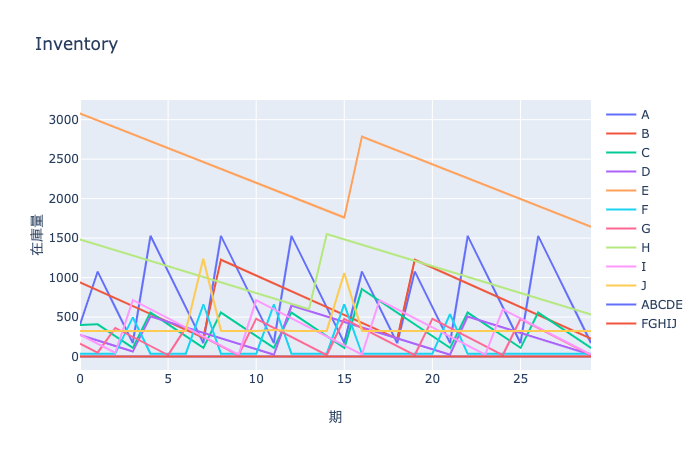

In [ ]:
#| echo: false
Image("../figure/fig_inv_for_lotsizing.png")

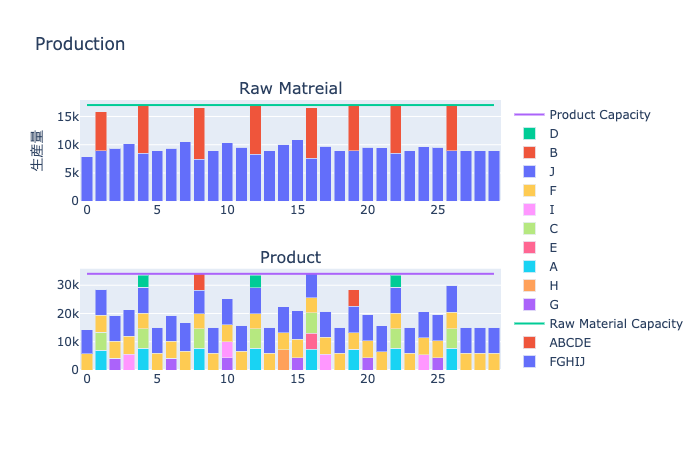

In [ ]:
#| echo: false
#fig_capacity.show()
Image("../figure/fig_capacity_for_lotsizing.png")

## 一般的なモデルのExcelデータテンプレートの生成

単に最適化を行うだけでなく，実際の運用で使うためのWebアプリとExcel連携

Webアプリで以下のものを入力

- 単位期間： 日や週や月などの計画単位期間を事前に決める．
- 計画期間の開始日と終了日


### 品目データ（マスタ）生成関数 generate_item_master

In [ ]:
#| export
def generate_item_master(wb):
    ws = wb.create_sheet(title="品目")
    ws.append(["品目名称", "在庫費用（円/期/unit)","在庫量下限","在庫量上限","初期在庫量","最終在庫量"])
    #初期在庫は別途Excelファイルでアップロード
    ws.cell(1,1).comment = Comment("品目の個別名称（ID)", "logopt")
    ws.cell(1,2).comment = Comment("１期あたりの在庫費用(円/unit/期）", "logopt")
    ws.cell(1,3).comment = Comment("在庫量の下限値；安全在庫量", "logopt")
    ws.cell(1,4).comment = Comment("在庫量の上限値；目標在庫量", "logopt")
    #初期と最終在庫量
    ws.cell(1,5).comment = Comment("計画期間の直前の期の期末在庫量", "logopt")
    ws.cell(1,6).comment = Comment("計画期間の終わり（最終期）の目標在庫量", "logopt")

    #データ検証
    dv = DataValidation(type="decimal",
                        operator="greaterThanOrEqual",
                        formula1=0.)
    dv.add('B2:F1048576') 
    ws.add_data_validation(dv)
    
    return wb

In [ ]:
wb = Workbook()
ws = wb.active
wb.remove(ws)
wb = generate_item_master(wb)                

### 工程データ（マスタ） 生成関数 generate_process_master

生産モードの概念を導入し，子品目数と資源数を入力する． このデータを元に部品展開表テンプレートと，資源必要量テンプレートを生成する．

In [ ]:
#| export
def generate_process_master(wb):
    ws = wb.create_sheet(title="工程")
    ws.append(["品目", "モード（複数可）", "段取り費用(円)", "生産費用(円/unit)", "子品目（原材料）数", "資源数"])
    #コメント
    ws.cell(1,1).comment = Comment("品目の名称（ID)（モードが複数の場合には空白も可）", "logopt")
    ws.cell(1,2).comment = Comment("生産モードの名称", "logopt")
    ws.cell(1,3).comment = Comment("段取り費用(円)", "logopt")
    ws.cell(1,4).comment = Comment("品目を1単位製造するために必要な費用(円)", "logopt")           
    ws.cell(1,5).comment = Comment("子品目（原材料）の数; ない場合には空白", "logopt")
    ws.cell(1,6).comment = Comment("生産に必要な資源数； 最低でも1つは登録", "logopt")                
    #データ検証（Noneは避けられない！）
    dv = DataValidation(type="decimal",
                        operator="greaterThanOrEqual",
                        formula1=0.)
    dv.add('C2:D1048576') 
    ws.add_data_validation(dv)
    #最低でも1のデータ検証
    dv2 = DataValidation(type="whole",
                        operator="greaterThanOrEqual",
                        formula1=1)
    dv2.add('E2:F1048576') 
    ws.add_data_validation(dv2)
    return wb

###  ロットサイズ決定システムのマスターExcel Workbookを生成する関数 generate_lotsize_master

品目と工程シートの他に， 資源名と基本容量を入れたシートをもつWorkbookを生成する．
これがロットサイズ決定システムのマスタデータになる．


In [ ]:
#| export
def generate_lotsize_master():
    wb = Workbook()
    ws = wb.active
    wb.remove(ws)
    wb = generate_item_master(wb) 
    wb = generate_process_master(wb)
    ws = wb.create_sheet(title="資源")
    ws.append(["資源名", "稼働時間上限（基準値）(h)"])
    #コメント
    ws.cell(1,1).comment = Comment("資源の個別名称（ID)", "logopt")
    ws.cell(1,2).comment = Comment("期ごとの稼働時間上限の基準値を入力（後で期別に変更可）", "logopt")
    
    #データ検証
    dv = DataValidation(type="decimal",
                        operator="greaterThanOrEqual",
                        formula1=0.)
    dv.add('B2:B1048576') 
    ws.add_data_validation(dv)
    
    return wb

In [ ]:
wb = generate_lotsize_master()
wb.save("optlot-master.xlsx")

### 部品展開表と資源必要量のシートを追加する関数 add_bom_resource_sheets

引数:
- wb: シート追加前のWorkbook； 工程シートに必要な子品目数と資源数を入れておく．

返り値：
- wb: 部品展開表と必要資源量のシートを追加したWorkbook


In [ ]:
#| export
def add_bom_resource_sheets(wb):
    #BOMとresource_reqの生成

    try:
        if wb["部品展開表"] is not None:
            wb.remove(wb["部品展開表"])
        if wb["資源必要量"] is not None:
            wb.remove(wb["資源必要量"])
    except:
        pass

    ws_bom = wb.create_sheet(title="部品展開表")
    ws_resource = wb.create_sheet(title="資源必要量")
 
    ws_bom.append(["品目", "モード", "子品目","必要量(units)"])
    ws_resource.append(["品目", "モード", "資源名", "段取り時間(分)", "生産時間(分/unit)"]) 

    #工程シートからデータ読み取り
    data = wb["工程"].values
    cols = next(data)[:]
    data = list(data)
    process_df = pd.DataFrame(data, columns=cols).dropna(how="all") 

    for row in process_df.itertuples():
        if row[1] is not None and not(np.isnan(row[0])):
            p = row[1] #parent
        else:
            p = "" #品目が空白
        m = row[2] #mode
        n_child = row[5]
        if n_child is not None and not(np.isnan(n_child)): #子品目数
            for i in range(int(n_child)):
                if i==0:
                    ws_bom.append([p, m, f"子品目{i+1}", 1] )
                else:
                    ws_bom.append(["","", f"子品目{i+1}", 1] )
        n_res = row[6]
        if n_res is not None and not(np.isnan(n_res)): #資源数
            for i in range(int(n_res)):
                if i==0:
                    ws_resource.append([p, m, f"資源{i+1}", 0.0, 0.0 ])
                else:
                    ws_resource.append(["","", f"資源{i+1}", 0.0, 0.0 ])

    #データ検証
    dv = DataValidation(type="decimal",
                        operator="greaterThanOrEqual",
                        formula1=0.)
    dv.add('D2:D1048576') 
    ws_bom.add_data_validation(dv)
    
    dv2 = DataValidation(type="decimal",
                        operator="greaterThanOrEqual",
                        formula1=0.)
    dv2.add('D2:E1048576') 
    ws_resource.add_data_validation(dv2)

    ws_bom.cell(1,3).comment = Comment("子品目の名称を品目シートから選んで変更してください．", "logopt")
    ws_bom.cell(1,4).comment = Comment("親品目を1単位製造するために必要な子品目の数量", "logopt")
    ws_resource.cell(1,3).comment = Comment("資源の名称を資源シートから選んで変更してください．", "logopt")
    ws_resource.cell(1,4).comment = Comment("資源の段取り時間(分)", "logopt")
    ws_resource.cell(1,5).comment = Comment("品目を1単位生産するための資源の使用時間(分)", "logopt")
    
    return wb

In [ ]:
# wb = load_workbook("lotsize-ex1.xlsx")
# wb = add_bom_resource_sheets(wb)
#wb.save("lotsize-ex1.xlsx")

###  資源データ入力Excelテンプレートの生成関数 

基本データをマスタで入力した後， Webアプリで開始日と終了日と期間(pandasの頻度(freq)パラメータ）を入力し，生成した期別の入力シートをダウンロードしてもらい， 
期別の容量（稼働時間上限）をExcelで入力し，アップロードする．これが， オペレーショナルに用いる資源データになる．

引数：
- wb: ロットサイズ決定のためのExcel Workbook
- start: 計画期間の開始日（日付時刻を表す文字列もしくは日付時刻型）
- finish: 計画期間の終了日（日付時刻を表す文字列もしくは日付時刻型）
- period: 期を構成する単位期間の数；既定値は $1$ 
- period_unit: 期の単位 （時，日，週，月から選択； 既定値は日； periodとあわせて期間の生成に用いる． たとえば，既定値だと１日が1期となる．

返値：
- wb: 資源の期別の容量（稼働時間上限）のシートを追加したWorkbook； シート名は「期別上限 開始日 終了日」となる．

In [ ]:
#| export
def add_detailed_resource_sheet(wb, start, finish, period=1, period_unit="日"):
                                
    trans = {"時":"h", "日":"d", "週":"w", "月":"M"}
    freq = f"{period}{trans[period_unit]}"
                                
    ws = wb.create_sheet(title=f"期別上限 {start} {finish}")
    time_index = pd.date_range(start, finish, freq= freq)
    ws.append(["資源名"]+list(time_index.strftime('%Y-%m-%d')))
    #資源シートからデータ読み取り
    res_master = wb["資源"]
    for row in res_master.iter_rows(min_row=2, min_col=1):
        ws.append([row[0].value]+[row[1].value]*len(time_index))

    #コメント
    ws.cell(2,1).comment = Comment("資源の個別名称（ID)", "logopt")
    ws.cell(2,2).comment = Comment("期ごとの稼働時間上限の基準値を入力", "logopt")

    #日付の列を回転
    for j in range(len(time_index)): 
        cell = ws.cell(1,j+2)
        cell.alignment = Alignment(horizontal = "center", vertical = "center", textRotation = 90, wrap_text = False)
    return wb

In [ ]:
# wb = load_workbook("lotsize-sample-new.xlsx")
# start = '2021-01-01' #開始日
# finish = '2021-01-5'
# period=1
# period_unit="日"
# wb = add_detailed_resource_sheet(wb, start, finish, period, period_unit)
# wb.save("lotsize-sample-new.xlsx")

In [ ]:
#開始日を設定し，需要を生成
# wb = load_workbook("optlot-master-at.xlsx")
# start = '2021-01-5' #開始日
# finish = '2021-12-17'
# period=1
# period_unit="日"
# wb = add_detailed_resource_sheet(wb, start, finish, period, period_unit)
# wb.save("optlot-master-at2.xlsx")

### 注文データ（品目の納期と数量） generate_order_excel

注文データ（品目の納期と数量）のテンプレートExcel Workbookを生成する．
これは，オペレーショナルデータである． これから需要量データを生成する．

In [ ]:
#| export
def generate_order_master():
    wb = Workbook()
    ws = wb.active
    wb.remove(ws)
    ws = wb.create_sheet(title="注文")
    ws.append(["品目(ID)", "納期", "数量"])

    #時間フォーマット
    for i in range(1000):
        ws.cell(2+i, 2).number_format = 'yyyy/m/d\\ h:mm;@'

    # #日付・時刻バリデーション
    dv = DataValidation(type="time") 
    ws.add_data_validation(dv)
    dv.add('B2:B1048576')   

    #コメント
    ws.cell(1,1).comment = Comment("品目の名称（ID)", "logopt")
    ws.cell(1,2).comment = Comment("納期を日付時刻型で入力", "logopt")
    ws.cell(1,3).comment = Comment("注文数量", "logopt")
    
    return wb

In [ ]:
wb = generate_order_master()
wb.save("order.xlsx")

### Excelブックの読み込みとデータ変換のための関数 read_dfs_from_excel_lot

引数
- wb: Excel Workbook

返値：
- item_df: 品目データフレーム
- process_df: 工程データフレーム
- resource_df: 資源データフレーム
- bom_df: 部品展開表データフレーム
- usage_df: 資源使用量データフレーム

In [ ]:
#| export
def read_dfs_from_excel_lot(wb):
    #item 
    data = wb["品目"].values
    cols = next(data)[:]
    data = list(data)
    item_df = pd.DataFrame(data, columns=cols).dropna(how="all") 

    #process
    data = wb["工程"].values
    cols = next(data)[:]
    data = list(data)
    process_df = pd.DataFrame(data, columns=cols).dropna(how="all") 

    #resource
    data = wb["資源"].values
    cols = next(data)[:]
    data = list(data)
    resource_df = pd.DataFrame(data, columns=cols).dropna(how="all") 
    
    data = wb["部品展開表"].values
    cols = next(data)[:]
    data = list(data)
    bom_df = pd.DataFrame(data, columns=cols).dropna(how="all") 

    data = wb["資源必要量"].values
    cols = next(data)[:]
    data = list(data)
    usage_df = pd.DataFrame(data, columns=cols).dropna(how="all") 
    
    return item_df, process_df, resource_df, bom_df, usage_df

### read_dfs_from_excel_lotの使用例

In [ ]:
# wb = load_workbook("optlot-master2-ex1.xlsx")
# item_df, process_df, resource_df, bom_df, usage_df = read_dfs_from_excel_lot(wb)
# print(item_df)
#print(process_df)
#print(resource_df)

           名称  在庫費用（円/期/unit)  在庫量下限  在庫量上限  初期在庫量  最終在庫量
0     Bottle6              54      0   1000      0      0
1        Can6              74      0   1000      0      0
2     Bottle1               8      0   1000      0      0
3        Can1               9      0   1000      0      0
4       Apple               1      0   1000      0      0
5  Watermelon               2      0   1000      0      0


### 注文Workbookから需要を生成する関数 generate_demand_from_order

引数
- wb: 注文情報を入れたExcel Workbook（シート名は注文）
- start: 開始日；日単位でない（たとえば1週単位の）場合には，開始日から1週間前からその開始日までが最初の期になる．
- finish: 終了日：日単位でない（たとえば1週単位の）場合には，生成したい週の最後の日が終了日以前である必要がある．
- period: 期を構成する単位期間の数；既定値は $1$ 
- period_unit: 期の単位 （時，日，週，月から選択； 既定値は日； periodとあわせて期間の生成に用いる． たとえば，既定値だと１日が1期となる．

返値
- demand: 品目 $p$ の期 $t$ の需要量 demand[t,p] を入れた辞書
- T: 計画期間数

In [ ]:
#| export
def generate_demand_from_order(wb, start, finish, period=1, period_unit="日"):
    
    trans = {"時":"h", "日":"d", "週":"w", "月":"M"}
    
    if period_unit=="週":
        weekday = pd.to_datetime(start).strftime('%a')
        freq = f"{period}{trans[period_unit]}-{weekday}"
    else:
        freq = f"{period}{trans[period_unit]}"

    data = wb["注文"].values
    cols = next(data)[:]
    data = list(data)
    order_df = pd.DataFrame(data, columns=cols).dropna(how="all") 
    order_df.columns = ["品目(ID)","納期","数量"] #列名を指定のものに直す！
    order_df["納期"] = pd.to_datetime(order_df["納期"])
    order_df.set_index("納期", inplace=True)
    order_grouped = order_df.groupby(["品目(ID)"]).resample(freq)["数量"].sum()
    #生成
    time_index = pd.date_range(start, finish, freq= freq)
    T = len(time_index)
    to_idx = {} #日付を期IDに変換するための辞書
    for t, t_idx in enumerate(time_index):
        date_ = t_idx.strftime('%Y-%m-%d')
        to_idx[date_] = t
    #需要量 demand[t,p]
    demand = defaultdict(float)
    for idx in order_grouped.keys():
        date_ = idx[1].strftime('%Y-%m-%d')
        val = order_grouped[idx]
        demand[to_idx[date_],idx[0]] = float(val)
    return demand, T

### generate_demand_from_orderの使用例

In [ ]:
wb = load_workbook("optlot-order-ex1.xlsx")
#開始日を設定し，需要を生成
start = '2021-01-01' #開始日
finish = '2021-01-05' #終了日
period=1
period_unit="日"
demand, T = generate_demand_from_order(wb, start, finish, period, period_unit)
print("Demand=",demand)
print("T=",T)

Demand= defaultdict(<class 'float'>, {(0, 'Bottle6'): 150.0, (1, 'Bottle6'): 200.0, (2, 'Bottle6'): 250.0, (3, 'Bottle6'): 230.0, (4, 'Bottle6'): 200.0, (0, 'Can6'): 120.0, (1, 'Can6'): 130.0, (2, 'Can6'): 160.0, (3, 'Can6'): 180.0, (4, 'Can6'): 200.0})
T= 5



### 期別資源使用量上限をもつWorkbookから情報を抽出する関数 get_resource_ub

引数
- wb: 注文情報を入れたExcel Workbook（期別資源使用量上限のシート名は「期別上限 {開始日} {終了日}」である必要がある．）
- start: 開始日；日単位でない（たとえば1週単位の）場合には，開始日から1週間前からその開始日までが最初の期になる．
- finish: 終了日：日単位でない（たとえば1週単位の）場合には，生成したい週の最後の日が終了日以前である必要がある．
- period: 期を構成する単位期間の数；既定値は $1$ 
- period_unit: 期の単位 （時，日，週，月から選択； 既定値は日； periodとあわせて期間の生成に用いる． たとえば，既定値だと１日が1期となる．

返値：
- M: 期別の資源量上限を表す辞書； 資源 $r$ の期 $t$ の上限が M[t,r] になる．

In [ ]:
#| export
def get_resource_ub(wb, start, finish, period=1, period_unit="日"):
    
    trans = {"時":"h", "日":"d", "週":"w", "月":"M"}
    if period_unit=="週":
        weekday = pd.to_datetime(start).strftime('%a')
        freq = f"{period}{trans[period_unit]}-{weekday}"
    else:
        freq = f"{period}{trans[period_unit]}"
        
    time_index = pd.date_range(start, finish, freq= freq)
    T = len(time_index)
    try:
        ws = wb[f"期別上限 {start} {finish}"]
        #print(f"期別上限 {start} {finish}")
    except KeyError as e: #期別上限シートがない場合
        #print(e)
        item_df, process_df, resource_df, bom_df, usage_df = read_dfs_from_excel_lot(wb)
        M = {}
        for row in resource_df.itertuples():
            for t in range(0,T):
                M[t, row[1]] = row[2]*60 #分に変更
        return M
    #期別上限シートがある場合 
    data = ws.values
    cols = next(data)[:]
    data = list(data)
    resource_ub_df = pd.DataFrame(data, columns=cols).dropna(how="all") 
    M ={}
    for row in resource_ub_df.itertuples():
        for t,j in enumerate(row[2:]):
            if pd.isnull(j):
                M[t,row[1]] = 0.
            else:
                M[t,row[1]] = float(j)*60 #分に変更
    return M

In [ ]:
# start = '2021-01-01' #開始日
# finish = '2021-01-25'
# period=1
# period_unit="日"
# wb = load_workbook("optlot-master2-ex1.xlsx")
# M = get_resource_ub(wb, start, finish, period, period_unit)
# print(M)

### 最適化結果Workbookの色情報を元に変数の固定情報を抽出する関数 extract_fix_info

出力のExcelシートに色を塗った箇所の生産（発注）量を固定する情報を抽出する．

引数
- wb: 最適化結果を入れた Excel Workbook
- start: 開始日；日単位でない（たとえば1週単位の）場合には，開始日から1週間前からその開始日までが最初の期になる．
- finish: 終了日：日単位でない（たとえば1週単位の）場合には，生成したい週の最後の日が終了日以前である必要がある．
- period: 期を構成する単位期間の数；既定値は $1$ 
- period_unit: 期の単位 （時，日，週，月から選択； 既定値は日； periodとあわせて期間の生成に用いる． たとえば，既定値だと１日が1期となる．

返値：
- fix_x: 変数 $x$ の固定情報；キーは「期番号，モード,アイテム」で値は固定したい数値を入れた辞書

In [ ]:
#| export
def extract_fix_info(wb, start, finish, period=1, period_unit="日"):
    
    trans = {"時":"h", "日":"d", "週":"w", "月":"M"}
    if period_unit=="週":
        weekday = pd.to_datetime(start).strftime('%a')
        freq = f"{period}{trans[period_unit]}-{weekday}"
    else:
        freq = f"{period}{trans[period_unit]}"
    time_index = pd.date_range(start, finish, freq= freq)
    T = len(time_index)
    to_idx = {} #日付を期IDに変換するための辞書
    for t, t_idx in enumerate(time_index):
        to_idx[t_idx.strftime('%Y-%m-%d')] = t

    fix_x = {}
    for name in wb.sheetnames:
        ws = wb[name]
        item = name[2:]
        for row in ws.iter_rows(min_row=3, min_col=2):
            if row[0].value !="生産量":
                break
            for cell in row[1:]:
                if cell.fill.fgColor.rgb != "00000000": #白以外の色の行を抽出
                    val = float(cell.value)
                    t = to_idx[ws.cell(1,cell.column).value]
                    m = ws.cell(cell.row,1).value[3:]
                    fix_x[t,m,item] = val
    return fix_x

#### extract_fix_info関数の使用例

In [ ]:
# wb = load_workbook("lotsize-out.xlsx")
# start = '2021-01-01' #開始日
# finish = '2021-01-25'
# period=1
# period_unit="日"
# fix_x = extract_fix_info(wb, start, finish, period=1, period_unit="日")
# fix_x

## 多モードロットサイズ決定問題を解く関数 multi_mode_lotsizing

引数：
- item_df: 品目データフレーム
- process_df: 工程データフレーム
- resource_df: 資源データフレーム
- bom_df: 部品展開表データフレーム
- usage_df: 資源使用量データフレーム
- demand: 需要量を入れた辞書
- capacity: 資源量上限を入れた辞書
- T: 計画期間数（既定値は $1$）
- fix_x: 変数固定情報を入れた辞書（既定値は None）

返値：
- model: モデルオブジェクト

In [ ]:
#| export
def multi_mode_lotsizing(item_df, resource_df, process_df, bom_df, usage_df, demand, capacity, T=1, fix_x=None):
    INF = 9999999999.
    h = {} #在庫費用
    IUB, ILB = {},{} #在庫量の下限と上限
    for row in item_df.itertuples():
        h[row[1]] = row[2]
        if pd.isnull(row[3]):
            ILB[row[1]] = 0.
        else:
            ILB[row[1]] = row[3]
        if pd.isnull(row[4]):
            IUB[row[1]] = INF # 在庫量上限がない場合
        else:
            IUB[row[1]] = row[4]

    #親子関係や資源必要量の辞書を作成
    parent = defaultdict(set) #子品目pを必要とする親品目とモードの組の集合
    phi = defaultdict(float) #親品目qをモードmで１単位生産するために必要な子品目pのunit数
    modes = defaultdict(set) #親品目qのモード集合
    resources = defaultdict(set) #親品目qをモードmで生産するときに必要な資源の集合
    setup_time = defaultdict(float)
    setup_cost = defaultdict(float)
    prod_time = defaultdict(float)
    prod_cost = defaultdict(float)

    items = item_df.iloc[:,0] #品目のリストを準備
    item_set = set(items)
    resource_set = set( resource_df.iloc[:,0])

    #resource内にない場合にエラーを起こす
    #品目にモードがない場合にもエラー
    for row in process_df.itertuples():
        if row[1] is not None:
            q = row[1]            
        if row[2] is not None: #モード
            m = row[2]
            modes[q].add(m)
        #費用
        if row[3] is None or np.isnan(row[3]):
            setup_cost[q,m] = 0.
        else:
            setup_cost[q,m] = row[3]
        if row[4] is None or np.isnan(row[4]):
            prod_cost[q,m] = 0.
        else:
            prod_cost[q,m] = row[4] 
            
    for q in items:        
        if len(modes[q])==0:
            raise ValueError(f"品目{q}にモードがありません．")
        
    #BOM
    for row in bom_df.itertuples():
        if row[1] is not None:
            q = row[1]            
        if row[2] is not None: #モード
            m = row[2]
        if row[3] is not None:
            p = row[3]
            phi[p,q,m] = row[4]
            parent[p].add( (q,m) )
        if q not in item_set:
            raise ValueError(f"品目{q}が品目シートにありません．")
        if p not in item_set:
            raise ValueError(f"品目{p}が品目シートにありません．")

    #usage
    for row in usage_df.itertuples():
        if row[1] is not None:
            q = row[1]            
        if row[2] is not None: #モード
            m = row[2]
        #資源と時間
        if row[3] is not None:
            r = row[3]
            resources[q,m].add(r) 
            if row[4] is None or np.isnan(row[4]):
                setup_time[q,m,r] = 0.
            else:
                setup_time[q,m,r] = row[4]
            if row[5] is None or np.isnan(row[5]):
                prod_time[q,m,r] = 0.
            else:
                prod_time[q,m,r] = row[5]

        if r not in resource_set:
            raise ValueError(f"資源{r}が資源シートにありません．")
        if q not in item_set:
            raise ValueError(f"品目{q}が品目シートにありません．")

    item_modes = defaultdict(set) #資源rを使用する品目とモードの組の集合（resourcesの逆写像）
    for key in resources:
        for r in resources[key]:
            item_modes[r].add(key)

    model = Model()
    x, I, y = {}, {}, {}
    slack, surplus = {}, {}
    inv_slack, inv_surplus = {}, {}
    Ts = range(0, T)

    for row in item_df.itertuples():
        p = row[1]
        for m in modes[p]:
            for t in Ts:
                x[t, m, p] = model.addVar(name=f"x({p},{m},{t})")
                I[t, p] = model.addVar(name=f"I({p},{t})") 
                y[t, m, p] = model.addVar(name=f"y({p},{m},{t})", vtype="B")
                slack[t, p] = model.addVar(name=f"slack({p},{t})")
                surplus[t, p] = model.addVar(name=f"surplus({p},{t})")
                inv_slack[t, p] = model.addVar(name=f"inv_slack({p},{t})")
                inv_surplus[t, p] = model.addVar(name=f"inv_surplus({p},{t})")
            if pd.isnull(row[5]):
                I[-1, p] = 0.
            else:
                I[-1, p] =  row[5]  # 初期在庫  

            if pd.isnull(row[6]):
                I[T-1,p] = 0.
            else:
                I[T-1,p] =  row[6]  # 最終期の在庫量            
    #各費用項目を別途合計する
    cost ={}
    for i in range(5):
        cost[i] = model.addVar(vtype="C",name=f"cost[{i}]")

    model.update()

    #変数の固定
    if fix_x is not None:
        for (t,m,p) in fix_x:
            model.addConstr( x[t,m,p] == fix_x[t,m,p] )

    #在庫量の上下限の逸脱の計算
    for t in Ts:
        for p in items:  
            model.addConstr( I[t, p] <= IUB[p] + inv_surplus[t,p], f"IUB({t},{p})" ) 
            model.addConstr( ILB[p]  <= I[t, p]+ inv_slack[t,p], f"ILB({t},{p})" ) 


    for row in resource_df.itertuples():
        r = row[1]
        for t in Ts:
            # time capacity constraints
            model.addConstr(quicksum(prod_time[p,m,r]*x[t,m,p] + setup_time[p,m,r]*y[t,m,p] for (p,m) in item_modes[r])
                            <= capacity[t,r], 
                            f"TimeConstraint1({r},{t})")

    for t in Ts:
        for p in items:
            # flow conservation constraints（ソフト制約）
            model.addConstr(I[t-1, p] + quicksum(x[t, m, p] for m in modes[p]) + slack[t, p] - surplus[t, p] == I[t, p] +demand[t,p]+
                         quicksum( phi[p,q,m]*x[t, m, q] for (q,m) in parent[p]), f"FlowCons({t},{p})" ) 

    for t in Ts:
        for p in items:  
            # capacity connection constraints
            for m in modes[p]:
                for r in resources[p,m]:
                    model.addConstr(prod_time[p,m,r]*x[t,m,p]
                                <=  (capacity[t,r]-setup_time[p,m,r])*y[t,m,p], f"ConstrUB({t},{m},{r},{p})")

    model.addConstr( quicksum( slack[t, p]+surplus[t, p] for t in Ts for p in items) == cost[0] )
    model.addConstr( quicksum( inv_slack[t, p]+inv_surplus[t, p] for t in Ts for p in items) == cost[1] )
    model.addConstr( quicksum( setup_cost[p,m]*y[t,m,p] for t in Ts for p in items for m in modes[p] for r in resources[p,m]) == cost[2])
    model.addConstr( quicksum( prod_cost[p,m]*x[t,m,p] for t in Ts  for p in items for m in modes[p] for r in resources[p,m]) == cost[3])
    model.addConstr( quicksum( h[p]*I[t, p] for t in Ts for p in items) == cost[4] )

    model.setObjective(9999999.*cost[0] + 999999.*cost[1] + quicksum(cost[i] for i in range(2,5)) , GRB.MINIMIZE)

    model.__data = x, I, y, slack, surplus, inv_slack, inv_surplus, cost, items, modes, item_modes, setup_time, prod_time, parent, resources
    
    return model

In [ ]:
#| include: false 
#テスト用
#開始日を設定し，需要を生成
# start = '2021-01-8' #開始日
# finish = '2021-02-28'
# period=1
# period_unit="週"

# trans = {"時":"h", "日":"d", "週":"w", "月":"M"}
    
# if period_unit=="週":
#     weekday = pd.to_datetime(start).strftime('%a')
#     freq = f"{period}{trans[period_unit]}-{weekday}"
# else:
#     freq = f"{period}{trans[period_unit]}"

# data = wb["注文"].values
# cols = next(data)[:]
# data = list(data)
# order_df = pd.DataFrame(data, columns=cols).dropna(how="all") 
# order_df.columns = ["品目(ID)","納期","数量"] #列名を指定のものに直す！
# order_df["納期"] = pd.to_datetime(order_df["納期"])
# order_df.set_index("納期", inplace=True)
# order_grouped = order_df.groupby(["品目(ID)"]).resample(freq, label='left')["数量"].sum()
# #生成
# time_index = pd.date_range(start, finish, freq= freq)
# T = len(time_index)
# to_idx = {} #日付を期IDに変換するための辞書
# for t, t_idx in enumerate(time_index):
#     to_idx[t_idx] = t
# #需要量 demand[t,p]
# demand = defaultdict(float)
# for idx, val in order_grouped.iteritems():
#     demand[to_idx[idx[1]],idx[0]] = float(val)
# print(time_index)
# #print(demand)

DatetimeIndex(['2021-01-08', '2021-01-15', '2021-01-22', '2021-01-29',
               '2021-02-05', '2021-02-12', '2021-02-19', '2021-02-26'],
              dtype='datetime64[ns]', freq='W-FRI')


### multi_mode_lotsizing関数の使用例

In [ ]:
#| include: false
#ライオン用
#from mypulp import GRB, quicksum, Model
#from pulp import PULP_CBC_CMD
# from gurobipy import GRB, quicksum, Model

# #開始日を設定し，需要を生成
# start = '2022-11-25' #開始日
# finish = '2023-02-26'
# period=1
# period_unit="週"

# wb = load_workbook("optlot-master-lion1.xlsx")
# item_df, process_df, resource_df, bom_df, usage_df = read_dfs_from_excel_lot(wb)

# M = get_resource_ub(wb, start, finish, period, period_unit)

# wb = load_workbook("optlot-order-lion1.xlsx")

# demand, T = generate_demand_from_order(wb, start, finish, period, period_unit)
# # print(demand,T)
    
# model = multi_mode_lotsizing(item_df, resource_df, process_df, bom_df, usage_df, demand, M, T, fix_x=None)

# model.optimize()
# #PULPの場合
# #solver = PULP_CBC_CMD(timeLimit=10, presolve=False)
# #model.optimize(solver)
# #SCIPの場合
# #solver = SCIP(timeLimit=10)
# #model.optimize(solver=solver)

# x, I, y, slack, surplus, inv_slack, inv_surplus, cost, items, modes, item_modes, setup_time, prod_time, parent, resources = model.__data

# print(model.Status)


In [ ]:
#| include: false ATカーニー用
#from mypulp import GRB, quicksum, Model
#from pulp import PULP_CBC_CMD
#from gurobipy import GRB, quicksum, Model

#開始日を設定し，需要を生成
# start = '2021-01-8' #開始日
# finish = '2021-02-26'
# period=1
# period_unit="週"

# wb = load_workbook("optlot-master-at.xlsx")
# item_df, process_df, resource_df, bom_df, usage_df = read_dfs_from_excel_lot(wb)

# M = get_resource_ub(wb, start, finish, period, period_unit)

# wb = load_workbook("optlot-order-at.xlsx")

# demand, T = generate_demand_from_order(wb, start, finish, period, period_unit)
# # print(demand,T)
    
# model = multi_mode_lotsizing(item_df, resource_df, process_df, bom_df, usage_df, demand, M, T, fix_x=None)

# model.optimize()
# #PULPの場合
# #solver = PULP_CBC_CMD(timeLimit=10, presolve=False)
# #model.optimize(solver)
# #SCIPの場合
# #solver = SCIP(timeLimit=10)
# #model.optimize(solver=solver)

# x, I, y, slack, surplus, inv_slack, inv_surplus, cost, items, modes, item_modes, setup_time, prod_time, parent, resources = model.__data

# print(model.Status)

In [ ]:
#| include: false
# print("slack=")
# for i in slack:
#     if slack[i].X >0.1:
#         print(i,slack[i].X)
# print("surplus=")    
# for i in surplus:
#     if surplus[i].X >0.1:
#         print(i,surplus[i].X)

In [ ]:
#| include: false
# INF = 9999999999.
# fix_x=None
# h = {} #在庫費用
# IUB, ILB = {},{} #在庫量の下限と上限
# for row in item_df.itertuples():
#     h[row[1]] = row[2]
#     if pd.isnull(row[3]):
#         ILB[row[1]] = 0.
#     else:
#         ILB[row[1]] = row[3]
#     if pd.isnull(row[4]):
#         IUB[row[1]] = INF # 在庫量上限がない場合
#     else:
#         IUB[row[1]] = row[4]

# #親子関係や資源必要量の辞書を作成
# parent = defaultdict(set) #子品目pを必要とする親品目とモードの組の集合
# phi = defaultdict(float) #親品目qをモードmで１単位生産するために必要な子品目pのunit数
# modes = defaultdict(set) #親品目qのモード集合
# resources = defaultdict(set) #親品目qをモードmで生産するときに必要な資源の集合
# setup_time = defaultdict(float)
# setup_cost = defaultdict(float)
# prod_time = defaultdict(float)
# prod_cost = defaultdict(float)

# items = item_df.iloc[:,0] #品目のリストを準備
# item_set = set(items)
# resource_set = set( resource_df.iloc[:,0])

# #resource内にない場合にエラーを起こす
# #品目にモードがない場合にもエラー
# for row in process_df.itertuples():
#     if row[1] is not None:
#         q = row[1]            
#     if row[2] is not None: #モード
#         m = row[2]
#         modes[q].add(m)
#     #費用
#     if row[3] is None or np.isnan(row[3]):
#         setup_cost[q,m] = 0.
#     else:
#         setup_cost[q,m] = row[3]
#     if row[4] is None or np.isnan(row[4]):
#         prod_cost[q,m] = 0.
#     else:
#         prod_cost[q,m] = row[4] 
        
# for q in items:        
#     if len(modes[q])==0:
#         raise ValueError(f"品目{q}にモードがありません．")
# #BOM
# for row in bom_df.itertuples():
#     if row[1] is not None:
#         q = row[1]            
#     if row[2] is not None: #モード
#         m = row[2]
#     if row[3] is not None:
#         p = row[3]
#         phi[p,q,m] = row[4]
#         parent[p].add( (q,m) )
#     if q not in item_set:
#         raise ValueError(f"品目{q}が品目シートにありません．")
#     if p not in item_set:
#         raise ValueError(f"品目{p}が品目シートにありません．")

# #usage
# for row in usage_df.itertuples():
#     if row[1] is not None:
#         q = row[1]            
#     if row[2] is not None: #モード
#         m = row[2]
#     #資源と時間
#     if row[3] is not None:
#         if r in resource_set and q in item_set:
#             r = row[3]
#             resources[q,m].add(r) 
#             if row[4] is None or np.isnan(row[4]):
#                 setup_time[q,m,r] = 0.
#             else:
#                 setup_time[q,m,r] = row[4]
#             if row[5] is None or np.isnan(row[5]):
#                 prod_time[q,m,r] = 0.
#             else:
#                 prod_time[q,m,r] = row[5]

# #     if r not in resource_set:
# #         raise ValueError(f"資源{r}が資源シートにありません．")
# #     if q not in item_set:
# #         raise ValueError(f"品目{q}が品目シートにありません．")

# item_modes = defaultdict(set) #資源rを使用する品目とモードの組の集合（resourcesの逆写像）
# for key in resources:
#     for r in resources[key]:
#         item_modes[r].add(key)

# model = Model()
# x, I, y = {}, {}, {}
# slack, surplus = {}, {}
# inv_slack, inv_surplus = {}, {}
# Ts = range(0, T)

# for row in item_df.itertuples():
#     p = row[1]
#     for m in modes[p]:
#         for t in Ts:
#             x[t, m, p] = model.addVar(name=f"x({p},{m},{t})")
#             I[t, p] = model.addVar(name=f"I({p},{t})") 
#             y[t, m, p] = model.addVar(name=f"y({p},{m},{t})", vtype="B")
#             slack[t, p] = model.addVar(name=f"slack({p},{t})")
#             surplus[t, p] = model.addVar(name=f"surplus({p},{t})")
#             inv_slack[t, p] = model.addVar(name=f"inv_slack({p},{t})")
#             inv_surplus[t, p] = model.addVar(name=f"inv_surplus({p},{t})")
#         if pd.isnull(row[5]):
#             I[-1, p] = 0.
#         else:
#             I[-1, p] =  row[5]  # 初期在庫  

#         if pd.isnull(row[6]):
#             I[T-1,p] = 0.
#         else:
#             I[T-1,p] =  row[6]  # 最終期の在庫量            
# #各費用項目を別途合計する
# cost ={}
# for i in range(5):
#     cost[i] = model.addVar(vtype="C",name=f"cost[{i}]")

# model.update()

# #変数の固定
# if fix_x is not None:
#     for (t,m,p) in fix_x:
#         model.addConstr( x[t,m,p] == fix_x[t,m,p] )

# #在庫量の上下限の逸脱の計算
# for t in Ts:
#     for p in items:  
#         model.addConstr( I[t, p] <= IUB[p] + inv_surplus[t,p], f"IUB({t},{p})" ) 
#         model.addConstr( ILB[p]  <= I[t, p]+ inv_slack[t,p], f"ILB({t},{p})" ) 


# for row in resource_df.itertuples():
#     r = row[1]
#     for t in Ts:
#         # time capacity constraints
#         model.addConstr(quicksum(prod_time[p,m,r]*x[t,m,p] + setup_time[p,m,r]*y[t,m,p] for (p,m) in item_modes[r]) <= M[t,r], 
#                         f"TimeConstraint1({r},{t})")

# for t in Ts:
#     for p in items:
#         # flow conservation constraints（ソフト制約）
#         model.addConstr(I[t-1, p] + quicksum(x[t, m, p] for m in modes[p]) + slack[t, p] - surplus[t, p] == I[t, p] +demand[t,p]+
#                      quicksum( phi[p,q,m]*x[t, m, q] for (q,m) in parent[p]), f"FlowCons({t},{p})" ) 

# for t in Ts:
#     for p in items:  
#         # capacity connection constraints
#         for m in modes[p]:
#             for r in resources[p,m]:
#                 model.addConstr(prod_time[p,m,r]*x[t,m,p]
#                             <=  (M[t,r]-setup_time[p,m,r])*y[t,m,p], f"ConstrUB({t},{m},{r},{p})")

# model.addConstr( quicksum( slack[t, p]+surplus[t, p] for t in Ts for p in items) == cost[0] )
# model.addConstr( quicksum( inv_slack[t, p]+inv_surplus[t, p] for t in Ts for p in items) == cost[1] )
# model.addConstr( quicksum( setup_cost[p,m]*y[t,m,p] for t in Ts for p in items for m in modes[p] for r in resources[p,m]) == cost[2])
# model.addConstr( quicksum( prod_cost[p,m]*x[t,m,p] for t in Ts  for p in items for m in modes[p] for r in resources[p,m]) == cost[3])
# model.addConstr( quicksum( h[p]*I[t, p] for t in Ts for p in items) == cost[4] )

# model.setObjective(99999999.*cost[0] + 999999.*cost[1] + quicksum(cost[i] for i in range(2,5)) , GRB.MINIMIZE)
# model.__data = x, I, y, slack, surplus, inv_slack, inv_surplus, cost, items, modes, item_modes, setup_time, prod_time, parent, resources

# model.optimize()

In [ ]:
# #開始日を設定し，需要を生成
# from pulp import PULP_CBC_CMD
# from mypulp import GRB, quicksum, Model

# order_wb = load_workbook("optlot-order-ex1.xlsx")
# start = '2021-01-1' #開始日
# finish = '2021-01-5'
# period=1
# period_unit="日"
# demand, T = generate_demand_from_order(order_wb, start, finish, period, period_unit)

# #資源量設定
# wb = load_workbook("optlot-master2-ex1.xlsx")
# item_df, process_df, resource_df, bom_df, usage_df = read_dfs_from_excel_lot(wb)
# M = get_resource_ub(wb, start, finish, period, period_unit)

# #変数固定情報
# result_wb = load_workbook("lotsize-out.xlsx")
# fix_x = extract_fix_info(result_wb, start, finish, period=1, period_unit="日")

# model = multi_mode_lotsizing(item_df, resource_df, process_df, bom_df, usage_df, demand, M, T, fix_x)
# model.Params.OutputFlag=False
# solver = PULP_CBC_CMD(timeLimit=100, presolve=True)
# model.optimize(solver)
# print(model.Status, model.ObjVal)
# #     class Status:
# #         OPTIMAL = 2
# #         INFEASIBLE = 3
# #         INF_OR_UNBD = 4
# #         UNBOUNDED = 5
# #         UNDEFINED = None
# x, I, y, slack, surplus, inv_slack, inv_surplus, cost, items, modes, item_modes, setup_time, prod_time, parent, resources = model.__data
# for v in y:
#     if y[v].X is not None and y[v].X > 0:
#         print(v,y[v].X, x[v].X)
# for i in cost:
#     print(cost[i].X)

### 最終期の在庫量を最適化するための方法

将来の不確実性を考慮するために，過去の需要量からブートストラップ（繰り返しを許したサンプリング）して未来の需要のシナリオを生成する．
シナリオごとに確定的な最適化を行い，それらの多数決もしくは期待値で行動を決める．



In [ ]:
#| include: false
# for row in order_df.itertuples():
#     q = row[1] #親品目
#     dem = row[3]
#     print("demand=",dem)
#     for t in range(T-1):
#         print(q,t,I[t,q].X)
#         for m in modes[q]:
#             print(x[t,m,q].X)

In [ ]:
#| include: false
# #activity = lot  
# #先行制約は親子関係から付加（それ以前に生産している期を探す；必要量が集まるまで先行制約を付加）
# model = optseq.Model()
# act, mode, res = {},{}, {}
# for r in item_modes:
#     res[r] = model.addResource(name=f"Resource[{r}]", capacity=1)

# for p in items:
#     for t in range(T):
#         for m in modes[p]:
#             if x[t,m,p].X > 0:
#                 act[t,m,p] = model.addActivity(name=f"act[{t},{m},{p}]", duedate= int( (time_index[t+1]-now).total_seconds()//60)  ) #納期は分に直す！
#                 max_prod_time = 0 #ロットサイズ決定のモードは固定する
#                 for r in resources[p,m]:
#                         if prod_time[p,m,r] > max_prod_time:
#                             max_prod_time = prod_time[p,m,r]
#                 mode[t,m,p] = optseq.Mode(name=f"mode[{t},{m},{p}]", duration= int(max_prod_time*x[t,m,p].X*60)+1 )
#                 for r in resources[p,m]:
#                     mode[t,m,p].addResource(res[r], requirement=1)
#                 act[t,m,p].addModes(mode[t,m,p])
#                 print(t,m,p,x[t,m,p].X, y[t,m,p].X)
# #先行制約
# for p in items:
#     for t in range(T):
#         for m in modes[p]:
#             if x[t,m,p].X > 0:
#                 dem = x[t,m,p].X
#                 while dem > 0:
#                     for t2 in range(t,-1,-1):
#                         for c in children[q,m]:
#                             for m2 in modes[c]:
#                                 if x[t2,m2,c].X >0:
#                                     #print(c,m2,t,x[t,m2,c].X)
#                                     print("Add time constraint", t,m,p,t2,m2,c)
#                                     dem -=x[t2,m2,c].X
#                                     model.addTemporal(act[t2,m2,c], act[t,m,p])
#model.optimize()

### 費用内訳のデータフレームを生成する関数 make_cost_df

In [ ]:
#| export
def make_cost_df(cost):
    df = pd.DataFrame({"需要逸脱ペナルティ":cost[0].X, "在庫上下限逸脱ペナルティ":cost[1].X,"段取り費用":cost[2].X, "生産変動費用":cost[3].X,"在庫費用":cost[4].X},index=["費用"])
    return df.T

### make_cost_dfの使用例

In [ ]:
# cost_df = make_cost_df(cost)
# cost_df

,費用
需要逸脱ペナルティ,0.000000e+00
在庫上下限逸脱ペナルティ,1.569742e+05
段取り費用,1.609179e+06
生産変動費用,1.371843e+06
在庫費用,1.122441e+07


### 最適化結果のExcelファイルを出力する関数 lot_output_excel
 
在庫・生産，需要量とシミュレーション用の関数を埋め込み
 
次の計画の初期在庫量は，このテンプレートの該当列になる． ローリングホライズンで行うために，以前のWorkbookを入れてそれに追加
 
引数
- model: ロットサイズ最適化のモデルオブジェクト
- start: 開始日；日単位でない（たとえば1週単位の）場合には，開始日から1週間前からその開始日までが最初の期になる．
- finish: 終了日：日単位でない（たとえば1週単位の）場合には，生成したい週の最後の日が終了日以前である必要がある．
- period: 期を構成する単位期間の数；既定値は $1$ 
- period_unit: 期の単位 （時，日，週，月から選択； 既定値は日； periodとあわせて期間の生成に用いる． たとえば，既定値だと１日が1期となる．
- demand: 需要を入れた辞書
- cost: 費用の変数を入れた辞書

返値：
- wb: 品目別の在庫量・生産量（モードごと）・需要量・品切れ量・超過量を入れたExcel Workbook

In [ ]:
#| export
def lot_output_excel(model, start, finish, period, period_unit, demand, cost_df): 

    trans ={"時":"h", "日":"d", "週":"w", "月":"M"}
    
    if period_unit=="週":
        weekday = pd.to_datetime(start).strftime('%a')
        freq = f"{period}{trans[period_unit]}-{weekday}"
    else:
        freq = f"{period}{trans[period_unit]}"
          
    x, I, y, slack, surplus, inv_slack, inv_surplus, cost, items, modes, item_modes, setup_time, prod_time, parent, resources = model.__data

    wb = Workbook()
    ws0 = wb.active
    wb.remove(ws0)
    time_index = pd.date_range(start, finish, freq= freq)
    T = len(time_index)
    
    ws = wb.create_sheet(title= "費用内訳")
    for r in dataframe_to_rows(cost_df, index=True, header=True):
        ws.append(r)
    
    for i in items:
        ws = wb.create_sheet(title= f"品目{i}")
        ws.append([""]*2 + list(time_index.strftime('%Y-%m-%d')))
        ws.append(["  ","在庫量"] + [I[t,i].X for t in range(T-1)]+[I[T-1,i]])  #T-1は最終期（在庫量は定数）
        for m in modes[i]:
            ws.append([f"モード{m}","生産量"] + [x[t,m,i].X for t in range(T)])  
        ws.append(["  ","需要量"] + [demand[t,i] for t in range(T)])
        ws.append(["  ","品切れ量"] + [slack[t,i].X for t in range(T)])
        ws.append(["  ","超過量"] + [surplus[t,i].X for t in range(T)])

        #日付の列を回転
        for j in range(T): 
            cell = ws.cell(1,j+3)
            cell.alignment = Alignment(horizontal = "center", vertical = "center", textRotation = 90, wrap_text = False)
    return wb

In [ ]:
#| include: false 
# cost_df = make_cost_df(cost)
# wb = lot_output_excel(model, start, finish, period, period_unit, demand, cost_df)
# wb.save("lotsize-out-at.xlsx")

### lot_output_excel関数の使用例

In [ ]:
# start = '2021-01-1' #開始日
# finish = '2021-01-5'
# period=1
# period_unit="日"
# cost_df = make_cost_df(cost)
# wb = lot_output_excel(model, start, finish, period, period_unit, demand, cost_df)
# wb.save("lotsize-out.xlsx")

### 多モードモデルの最適化結果の図を生成する関数 show_result_for_multimode_lotsizing


引数
- model: ロットサイズ最適化のモデルオブジェクト
- start: 開始日；日単位でない（たとえば1週単位の）場合には，開始日から1週間前からその開始日までが最初の期になる．
- finish: 終了日：日単位でない（たとえば1週単位の）場合には，生成したい週の最後の日が終了日以前である必要がある．
- period: 期を構成する単位期間の数；既定値は $1$ 
- period_unit: 期の単位 （時，日，週，月から選択； 既定値は日； periodとあわせて期間の生成に用いる． たとえば，既定値だと１日が1期となる．
- capacity: 資源量上限を入れた辞書

返値：
- fig_inv : 在庫量の推移を表した図オブジェクト
- fig_capacity : 容量制約を表した図オブジェクト

In [ ]:
#| export
def show_result_for_multimode_lotsizing(model, start, finish, period, period_unit, capacity):

    #在庫プロット
    trans = {"時":"h", "日":"d", "週":"w", "月":"M"}

    if period_unit=="週":
        weekday = pd.to_datetime(start).strftime('%a')
        freq = f"{period}{trans[period_unit]}-{weekday}"
    else:
        freq = f"{period}{trans[period_unit]}"

    time_index = pd.date_range(start, finish, freq= freq)

    (x, I, y, slack, surplus, inv_slack, inv_surplus, cost, items, modes, item_modes, setup_time, 
     prod_time, parent, resources) = model.__data
        
    xrange =  list(time_index.strftime('%Y-%m-%d'))
    T = len(time_index)

    data =[]
    for i in items:
        trace = go.Scatter( x=xrange, y = [I[t,i].X for t in range(T-1)]+[I[T-1,i]], name=str(i) )
        data.append( trace)
    layout = go.Layout(
        autosize = True,
        title = "Inventory",
        xaxis=dict(
                title='期'
              ),
        yaxis=dict(
                title='在庫量'
              ),
    )
    fig_inv = go.Figure(data=data, layout=layout)
    
    # 容量制約の図
    fig = make_subplots(rows=len(item_modes), cols=1,
                        subplot_titles=[ f"資源{r}" for r in item_modes])
    
    for idx, r in enumerate(item_modes):
        for i,m in item_modes[r]:
            trace = go.Bar( x= xrange, y = [prod_time[i,m,r]*x[t,m,i].X + setup_time[i,m,r]*y[t,m,i].X for t in range(T)], 
                           name= f"Item{i} Mode{m}")
            fig.add_trace(trace, row=idx+1, col=1)
            fig.add_trace(go.Scatter( x= xrange, y = [capacity[t,r] for t in range(T)], name= f"生産容量{r}") , row=idx+1, col=1)

    fig.update_layout(
        barmode='stack',
        autosize = False,
        width = 1400, 
        height=150*len(item_modes),
        title = "資源別生産量",
        yaxis=dict(
                title='生産量'
              ),
    )
    return fig_inv, fig

In [ ]:
#| include: false ATカーニー用
# period=1
# period_unit="週"
# fig_inv, fig = show_result_for_multimode_lotsizing(model, start, finish, period, period_unit, M)

# plotly.offline.plot(fig);
# plotly.offline.plot(fig_inv);
# fig.write_html("resource.html")
# fig_inv.write_html("inv.html")

#### show_result_for_multimode_lotsizing関数の使用例

In [ ]:
# start = '2021-01-1' #開始日
# finish = '2021-01-5' #終了日

# period=1
# period_unit="日"
# fig_inv, fig = show_result_for_multimode_lotsizing(model, start, finish, period, period_unit, M)

# plotly.offline.plot(fig);
# plotly.offline.plot(fig_inv);

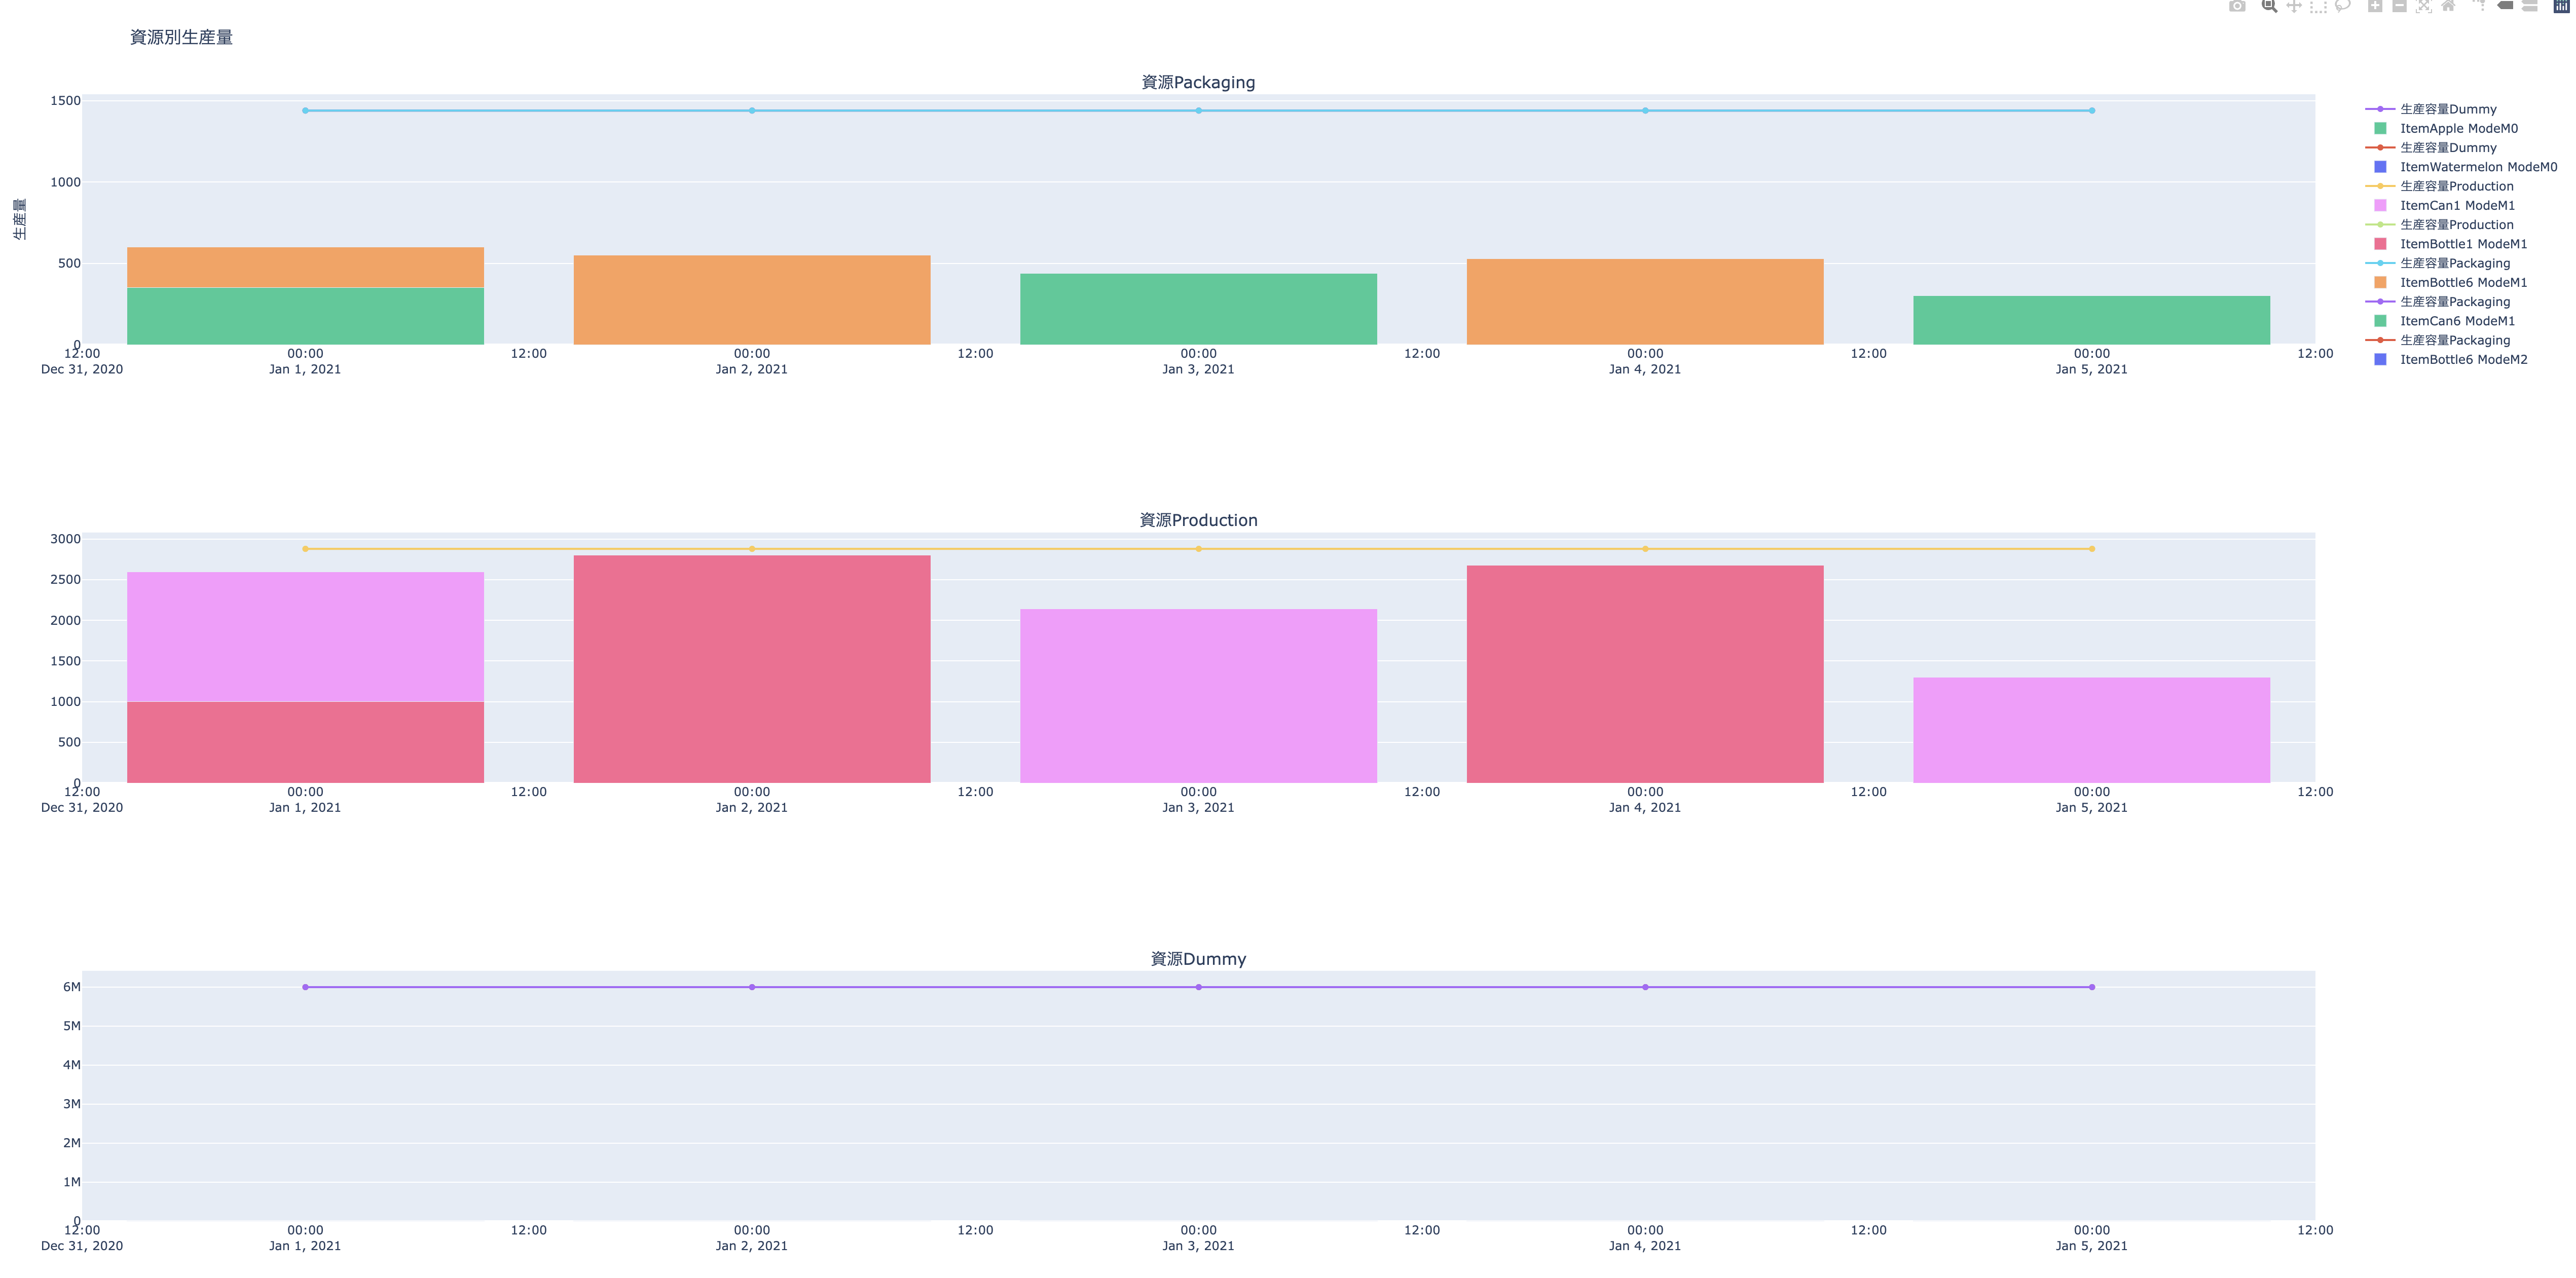

In [ ]:
#| echo: false
Image("../figure/lot-resource.png")

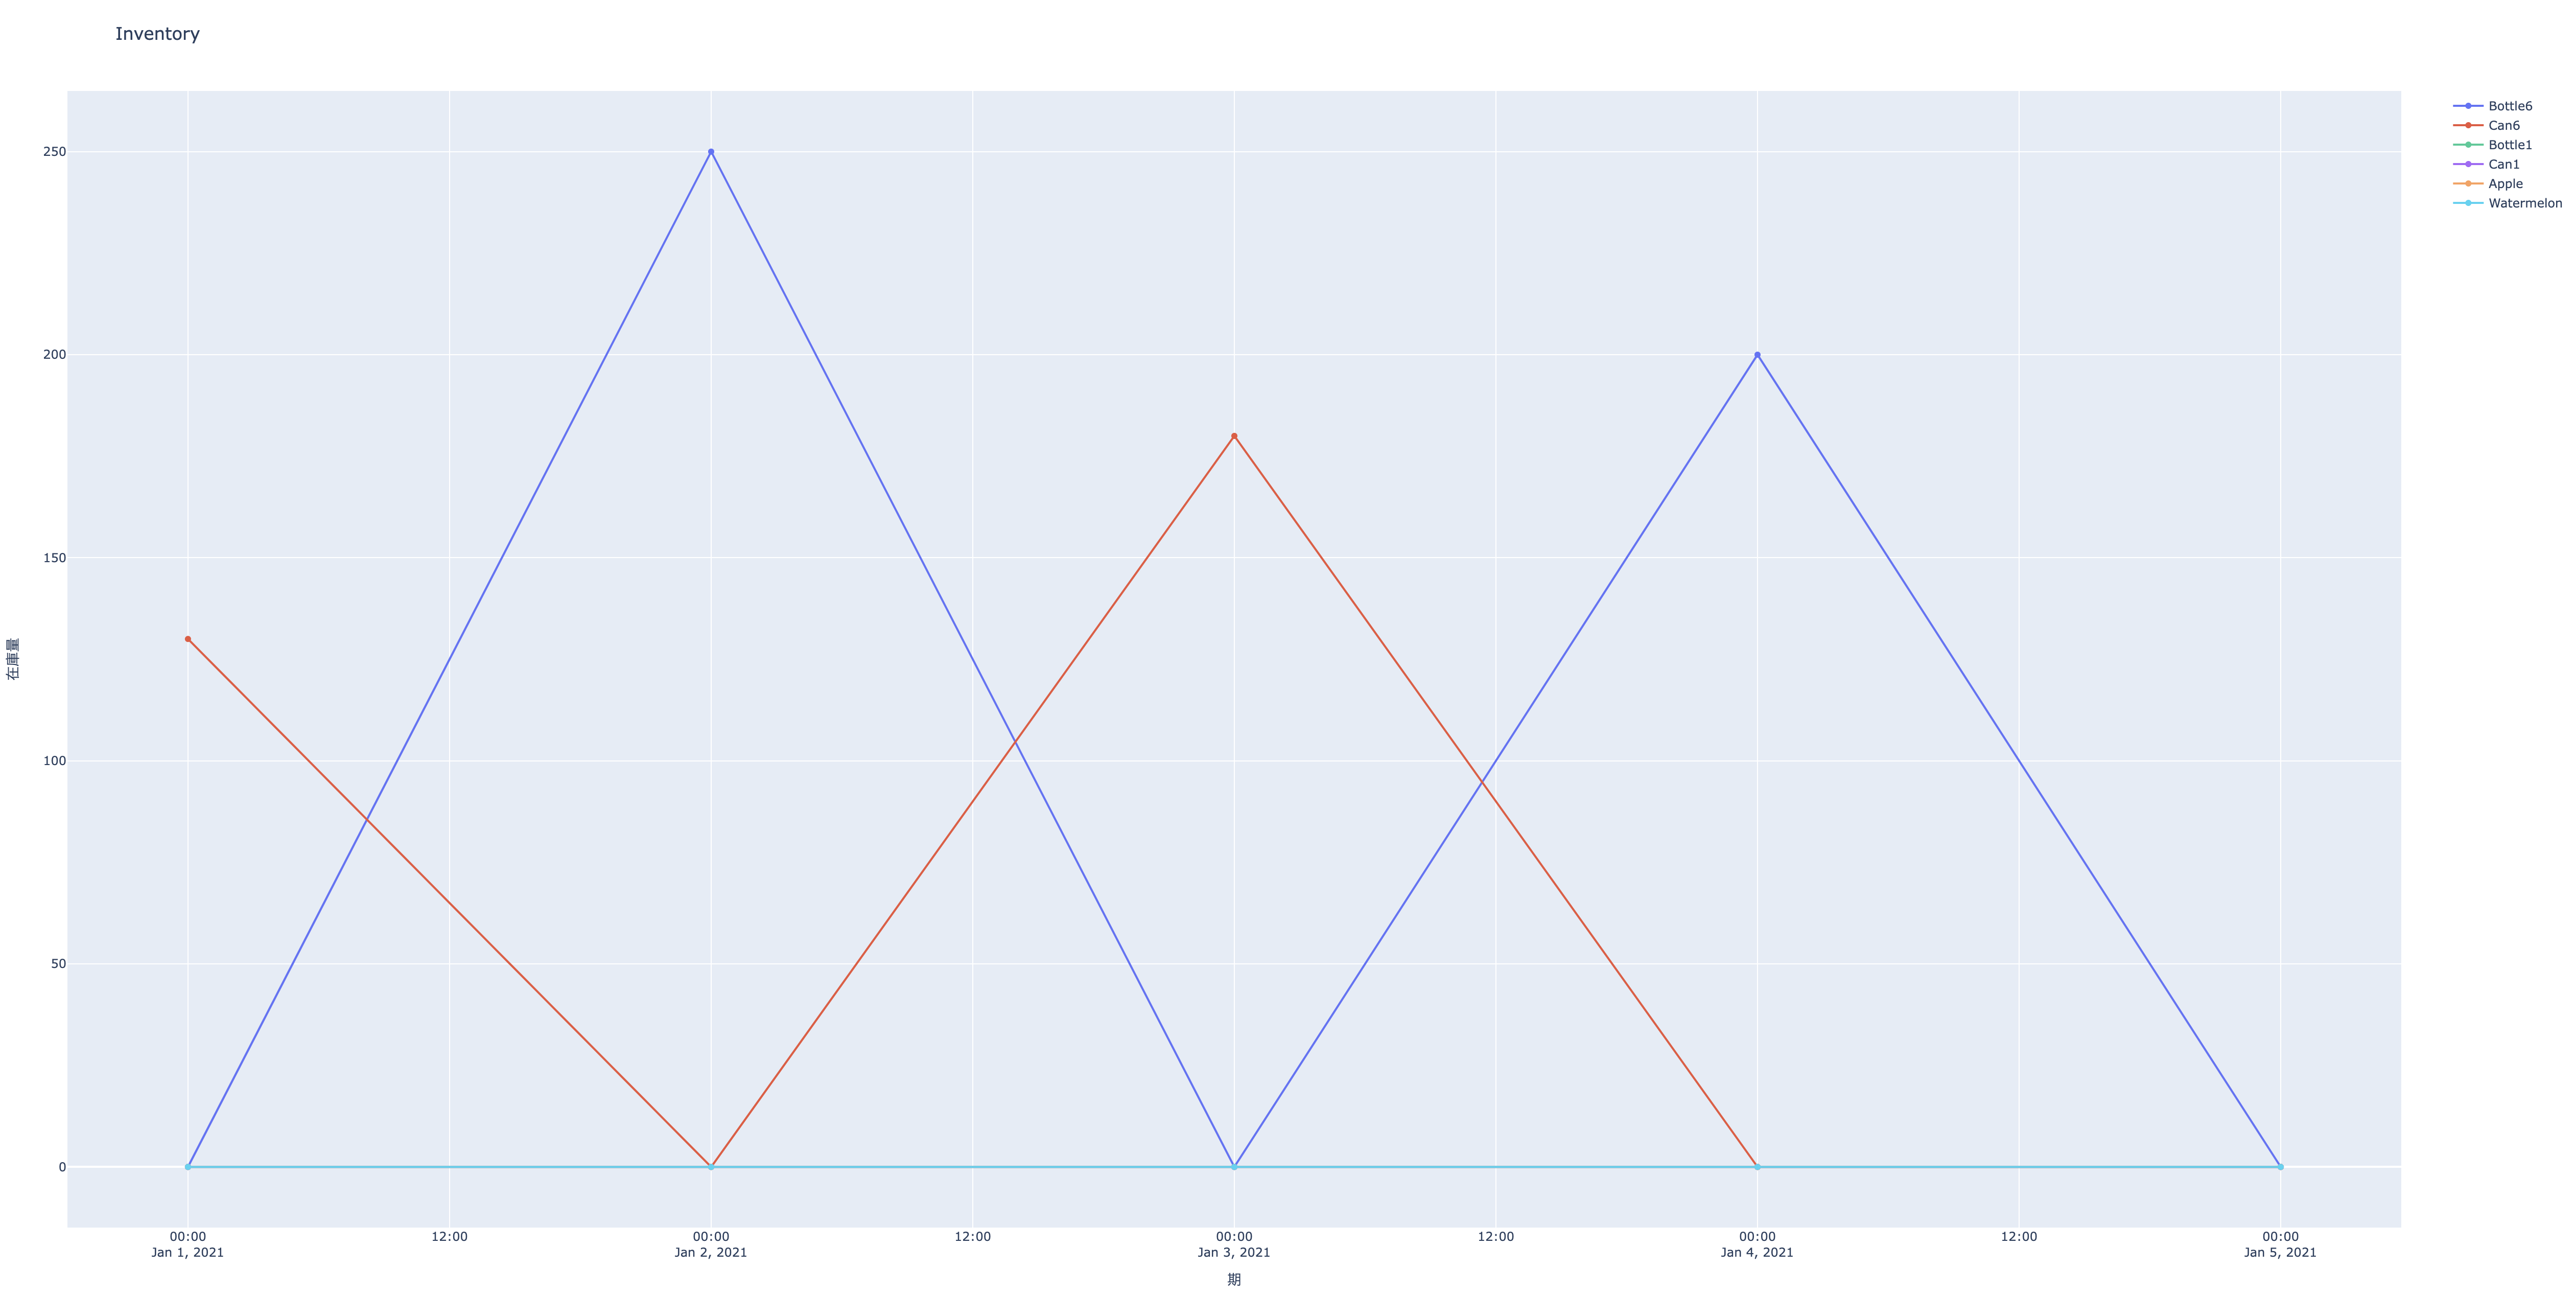

In [ ]:
#| echo: false
Image("../figure/lot-inv.png")

In [ ]:
#| include: false
# #生産と需要の紐付け； t期に生産したものがj期で使用されている量； X[t,j,p]>0になる最小のjが納期になる．
# #もしくはフロー分解？
# X ={}
# for p in items:
#     for t in range(T):
#         for j in range(t,T):
#             X[t,j,p] = 0.
#             for m in modes[p]:
#                 X[t,j,p] += x[t,m,p].X
#             for q,m in parent[p]:
#                 X[t,j,p] -= x[t,m,q].X
#             for k in range(t,j):
#                 X[t,j,p] -= demand[k,p]
                
#             X[t,j,p] = X[t,j,p] - I[j,p].X if j<T-1 else  X[t,j,p] - I[j,p]
#     for t in range(T):
#         for j in range(t,T):
#             if X[t,j,p]>0:
#                 print(t,j,p,X[t,j,p])

#| include: false
## 生産計画・スケジューリングのためのヒヤリングメモ

- 見込み生産か受注生産か: 需要予測を行っている場合には見込み生産， 顧客からの注文が生産計画の始点となっている場合には受注生産とみなす．
もちろん， 中間製品（部品）は見込みで生産し， その後の完成品の生産は注文があってから開始する場合もある． 
その場合には，受注生産（引っ張り）と見込み（押し出し）の境界の工程（push-pull boundary)をヒヤリングしておく． 
中間製品（部品）の安全在庫がたくさんある地点がこれに該当する．
ここで安全在庫とは，予測誤差に対処するための緩衝用の在庫である．
通常のサイクル（仕掛り）在庫ではないことに注意されたい．
工程ごとのロットまとめの基準が異なる場合には， 工程間に比較的多くの在庫が滞留することがある（製鉄が代表的である）． 
このような中間在庫はロットサイズ在庫とみなす．

- ロットまとめが重要か： 生産を行う際に，まとめて生産を行っている場合には，ロットサイズ決定モデルを用いる必要がある． ロット生産する際のおおよその段取り時間と段取り費用もヒヤリングしておく．
小さな生産ロットごとに必要な簡易な段取りは，生産時間に含めて考えることができるので，無視して良い．
また，段取り時間（費用）が順序依存なのか，順序に依存しないかもヒヤリングしておく．

- 部品展開表（BOM）情報： 主要な完成品とその生産に必要な主要な中間製品（部品）と原材料についてヒヤリングする．

- 工程情報： 製品製造のおおよその流れと工程数，ならびにボトルネックになっている工程があるかをヒヤリングする． 

- 資源情報： 生産を行う際にボトルネックになっている製造設備（人員）についてヒヤリングしておく． 

- 計画期間： スケジューリング最適化の対象とする計画期間は，すべての情報が集まっていて最適化が可能な期間のことである． 
将来を不確実な需要予測をもとにした生産最適化の計画期間と区別してヒヤリングする． 現場では，大日程と小日程と言った方が通じるかもしれない．

- 最適化の対象とする範囲の決定： はじめは重要だが小規模の問題に絞って検証実験をした方が良い． クライアントにPoCの対象範囲を決めてもらうことが望ましい．


## 安全在庫配置ならびに在庫最適化のためのヒヤリングメモ

- 複数拠点での在庫最適化なのか1拠点だけなのか
- 計画期間（タクティカルかオペレーショナルか）： 
長期にわたるサプライ・チェイン全体でのリード時間決定なら安全在庫配置モデル，短期の少数拠点の在庫方策決定なら
確率的在庫モデル
- サプライ・チェイン全体での在庫最適化の場合： グラフとして描いてもらう．
- 拠点間のリード時間： ある在庫地点が商品の供給地点に発注してから商品が到着するまでの時間（保証リード時間，サービス時間）を指す．
商品が到着してから出荷可能になるまでの時間（生産時間）と区別する必要がある．
- 各拠点での商品の（おおよその）価値もしくは在庫費用，もしくは原材料の調達費用と各地点での付加価値（かかった費用）
- 最終顧客への保証リード（サービス）時間
- 需要データの有無
- 需要の季節変動の有無

## 配送最適化のためのヒヤリングメモ

- デポ数， トラックの車種別の数， 顧客数， 区別すべき荷（常温，冷蔵，冷凍など）の数
- デポならびに積み込み地点と積み下ろし地点（顧客）の情報： 住所，緯度経度，入庫可能なトラックの種類など
- 荷の分割の可否
- 高速利用の可否
- 時間枠（指定）の数と種類
- 休憩のとりかたについてのコンセンサス
- トラックの車種別の時速設定についてのコンセンサス
- 中継地点での荷のリレーの可否
- 運転ルールの確認（なるべく右折を避ける，Uターン禁止など）

## ネットワーク設計のためのヒヤリングメモ

- サプライ・チェイン全体でのモノの移動をグラフとして描いてもらう
- 製品数，拠点（工場，倉庫，顧客）の数
- 最適化する範囲の決定
- 顧客や製品が多い場合には，集約の可否
- 地点間の費用（料率表）の確認，もしくはトンキロで近似するための過去の実績の有無を聞く
- 地点の住所，緯度経度の有無
- トラック以外の輸送手段の料率表と運行スケジュール
- リスク要因を組み込むか否か